Starting analysis for topology: linear_20N

Processing Configuration: linear_20N / ideal
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9660
  Std. Dev. of PDR (run-to-run): 0.0130
  (Based on 100 simulation runs)


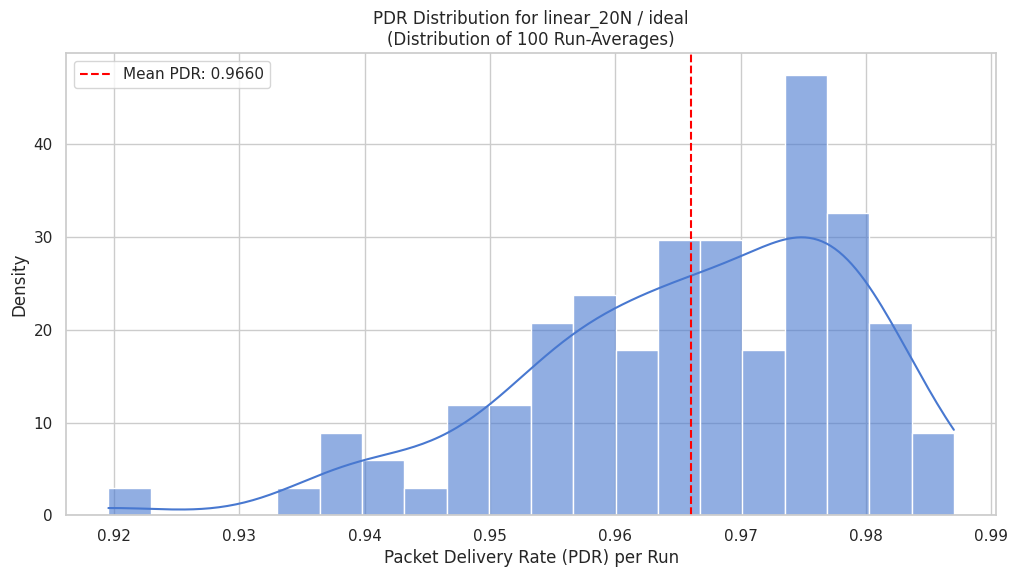


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0065 s
  Std. Dev. of Latency (all packets): 0.0025 s
  (Based on 55045 total packets delivered across all runs)


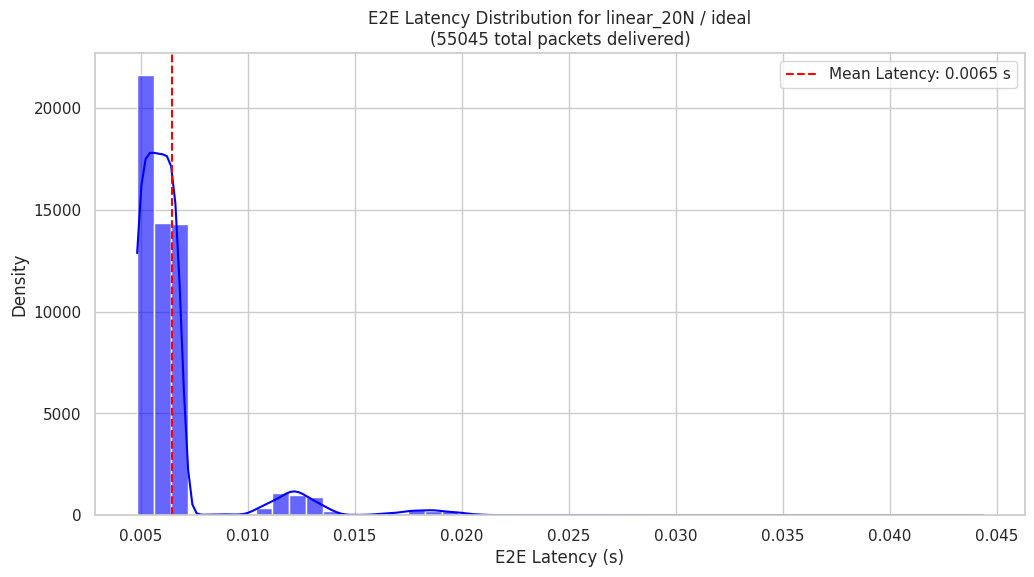



Processing Configuration: linear_20N / lossy
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9771
  Std. Dev. of PDR (run-to-run): 0.0098
  (Based on 100 simulation runs)


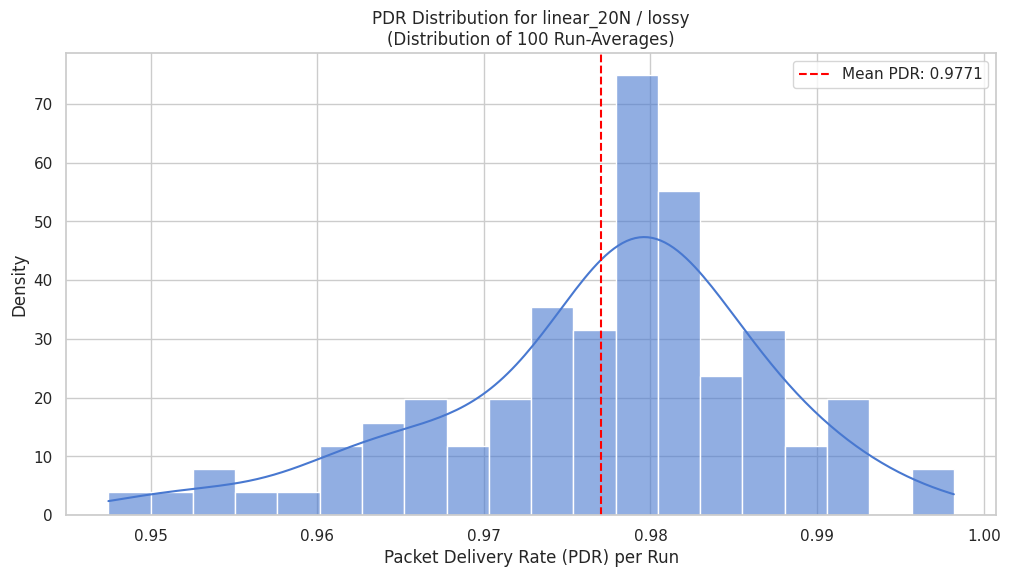


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0075 s
  Std. Dev. of Latency (all packets): 0.0044 s
  (Based on 55594 total packets delivered across all runs)


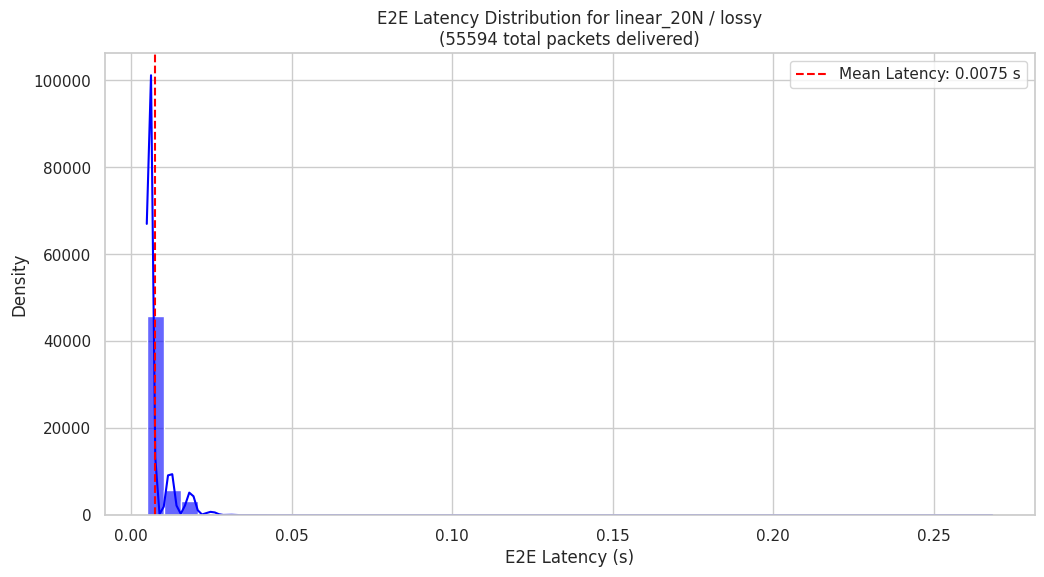



Processing Configuration: linear_20N / stable
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9653
  Std. Dev. of PDR (run-to-run): 0.0133
  (Based on 100 simulation runs)


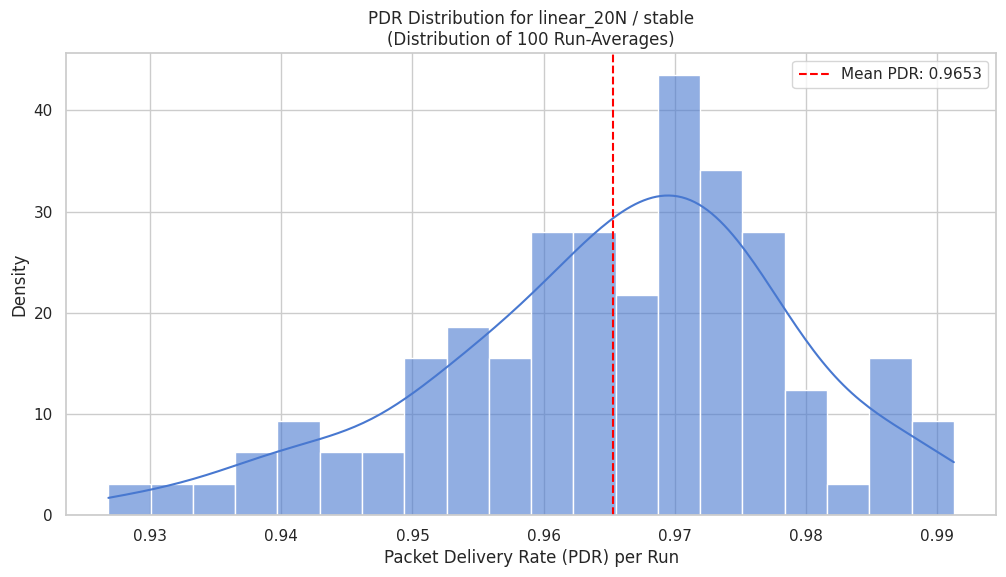


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0065 s
  Std. Dev. of Latency (all packets): 0.0028 s
  (Based on 55003 total packets delivered across all runs)


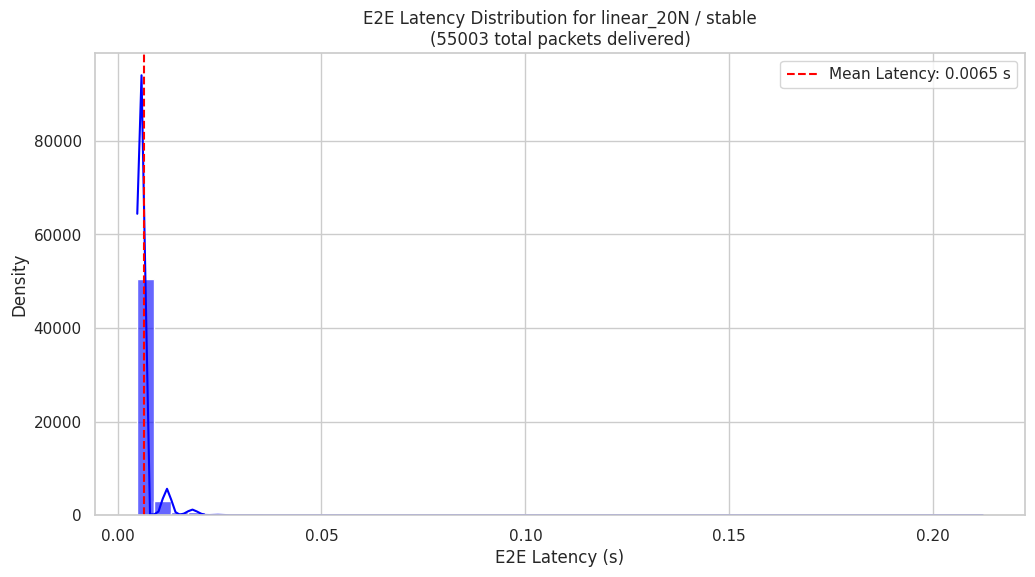



Processing Configuration: linear_20N / stable_high_pl
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9336
  Std. Dev. of PDR (run-to-run): 0.0214
  (Based on 100 simulation runs)


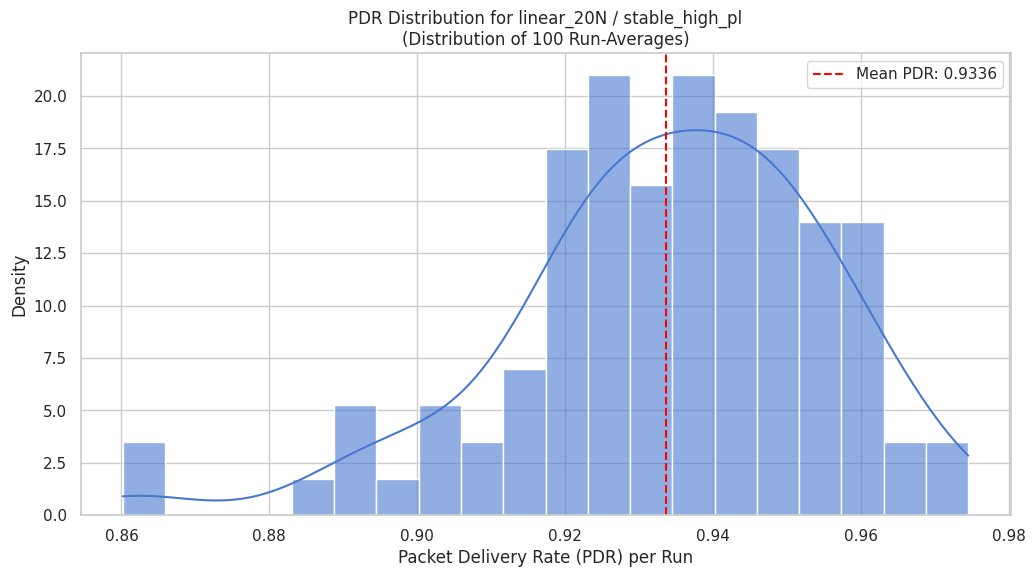


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0113 s
  Std. Dev. of Latency (all packets): 0.0083 s
  (Based on 53048 total packets delivered across all runs)


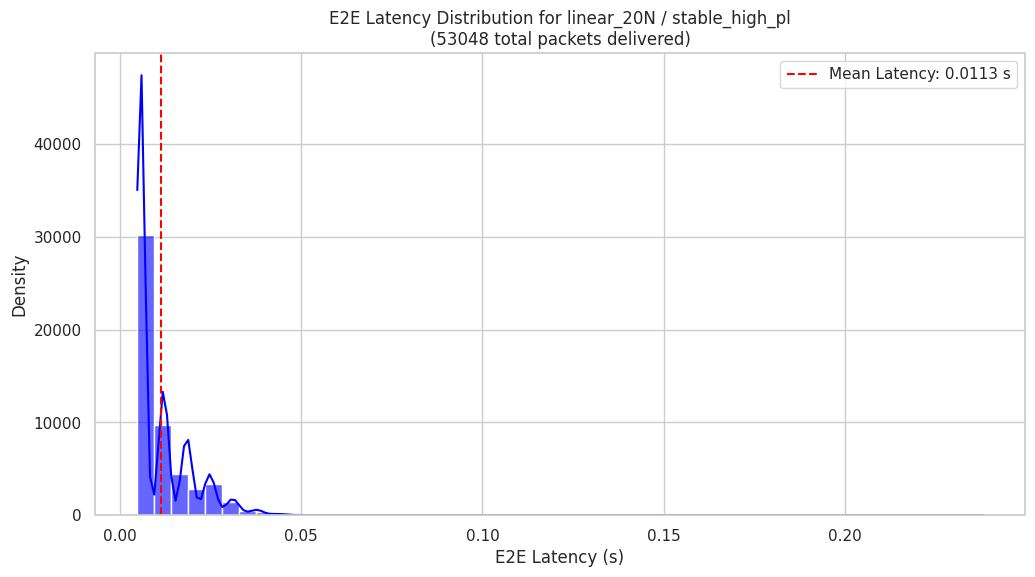



Processing Configuration: linear_20N / stable_mid_pl
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9793
  Std. Dev. of PDR (run-to-run): 0.0108
  (Based on 100 simulation runs)


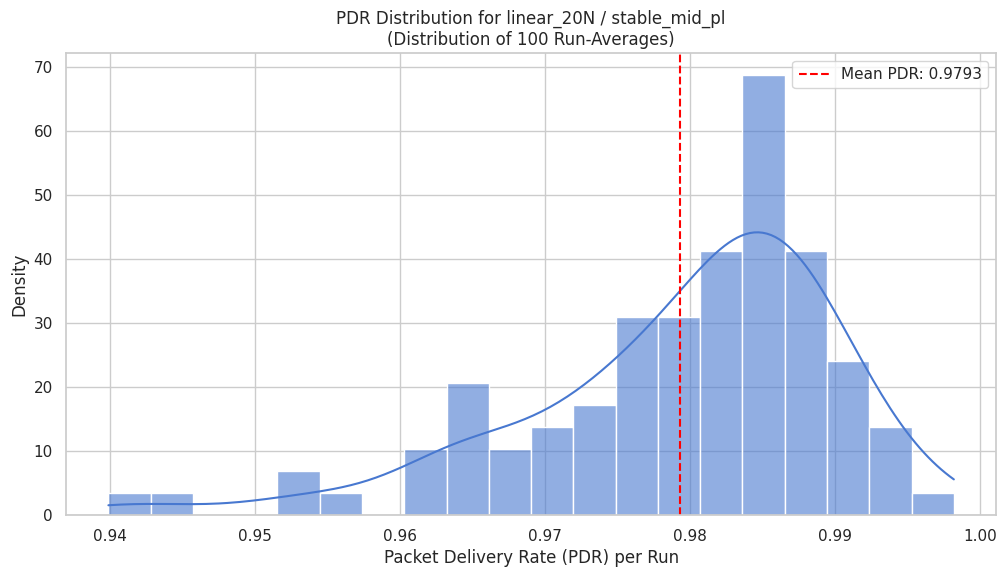


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0070 s
  Std. Dev. of Latency (all packets): 0.0034 s
  (Based on 55755 total packets delivered across all runs)


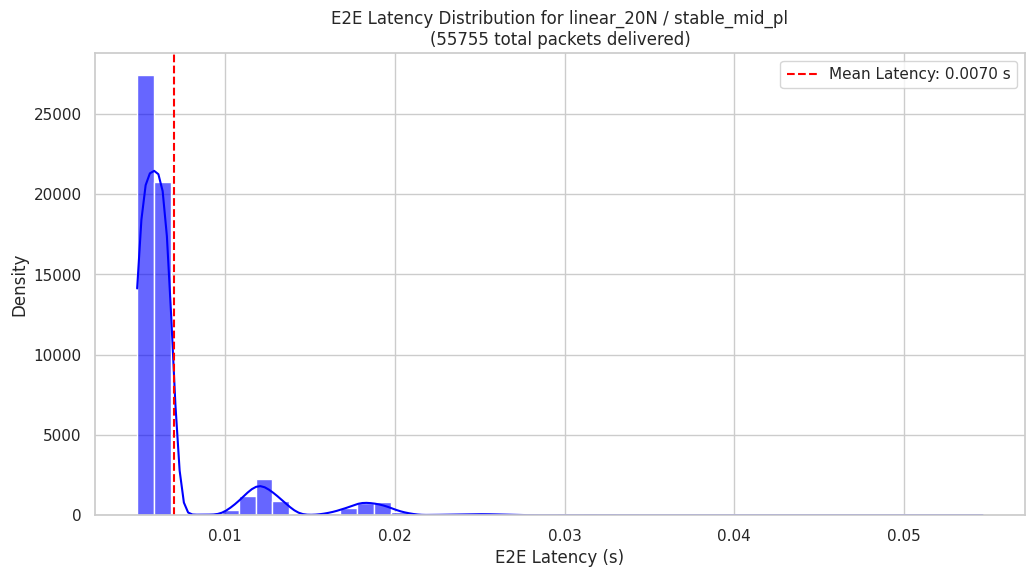



Processing Configuration: linear_20N / unstable
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.8883
  Std. Dev. of PDR (run-to-run): 0.0331
  (Based on 100 simulation runs)


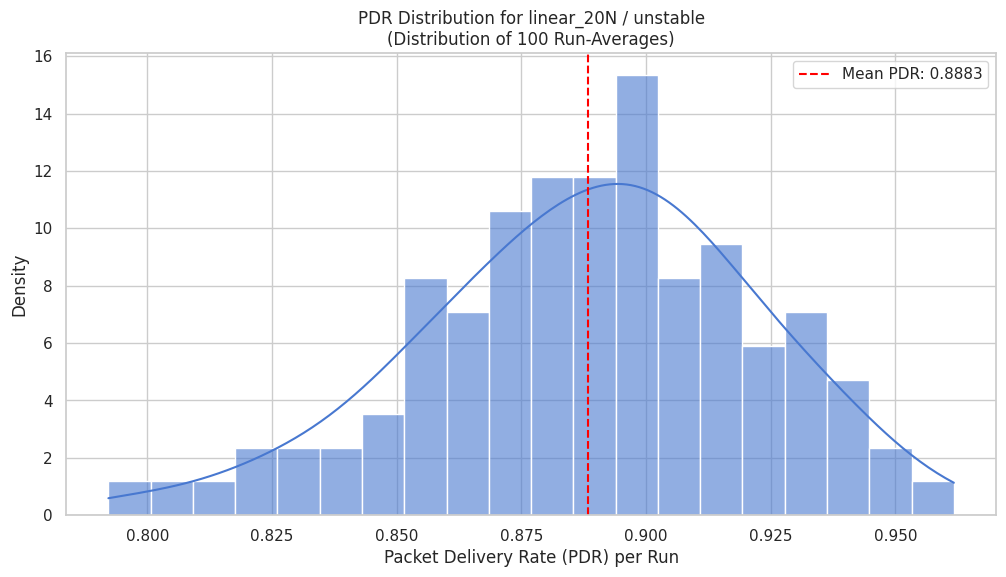


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0131 s
  Std. Dev. of Latency (all packets): 0.0111 s
  (Based on 50367 total packets delivered across all runs)


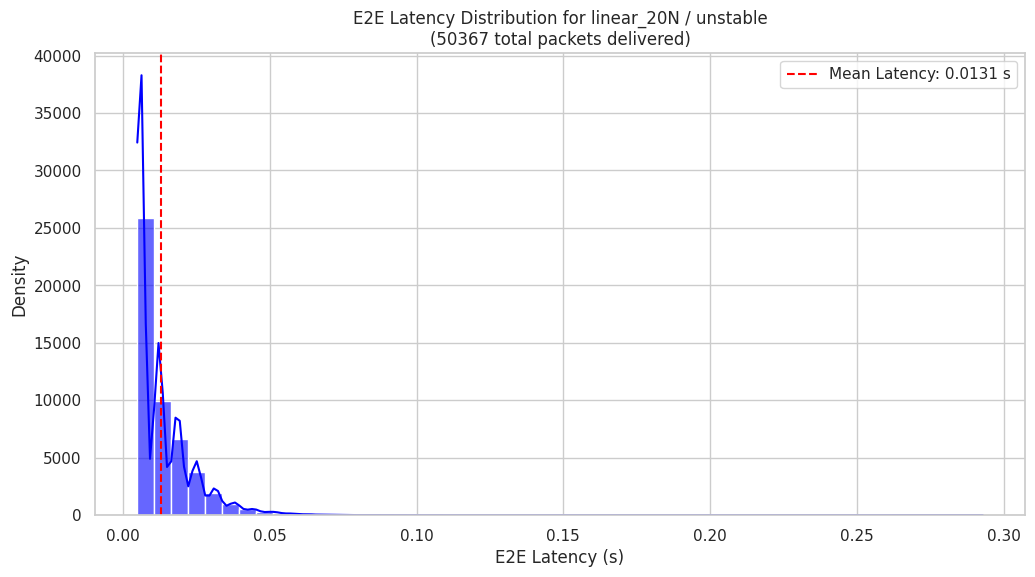



Analysis complete.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

# =============================================================================
# --- Configuration ---
# =============================================================================


# 1. Set this to the parent directory containing your topology folders
#    (e.g., the 'poisson_traffic' folder that holds 'random_20nodes')
PATH_TO_RESULTS_PARENT_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57")

# 2. Set this to the specific topology folder you want to analyze
#    (e.g., "random_20nodes" or "cluster-tree_20nodes")
TOPOLOGY_FOLDER_TO_ANALYZE = "linear_20N"

# --- End of Configuration ---


# Log file names (as defined in run_simulation.py and monitors)
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

# Set plot style for better aesthetics
sns.set(style="whitegrid", palette="muted")
# Suppress warnings from seaborn when data is missing for KDE
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# =============================================================================
# --- Helper Functions ---
# =============================================================================

def process_pdr_file(file_path):
    """
    Reads a single PDR log file from one run (seed).
    Calculates the PDR for that run (which is the mean of the 'delivered' column).
    Returns the PDR value (float) or None if the file is invalid.
    """
    try:
        # Load the CSV. We use skipinitialspace to handle
        # the potential leading space in the header row.
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:
            print(f"  - WARNING: PDR file is empty, skipping: {file_path}", file=sys.stderr)
            return None
        
        #
        # The 'delivered' column is 0 or 1. The mean of this column
        # is the Packet Delivery Rate for this simulation run.
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        # This is not an error, it just means the simulation run failed to
        # produce this file. We will report it and skip it.
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        print(f"  - WARNING: PDR file is empty (EmptyDataError), skipping: {file_path}", file=sys.stderr)
        return None
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None

def process_latency_file(file_path):
    """
    Reads a single E2E Latency log file from one run (seed).
    Returns a list of all individual packet latencies from that run.
    Returns an empty list if the file is invalid or no packets were delivered.
    """
    try:
        #
        # The 'latency' column contains the E2E latency for each received packet.
        df_lat = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_lat.empty:
            # This is not an error; it just means PDR was 0.
            return []
        
        if 'latency' not in df_lat.columns:
            print(f"  - ERROR: 'latency' column not found in: {file_path}", file=sys.stderr)
            return []
            
        # Return all latencies from this run
        return df_lat['latency'].tolist()
        
    except FileNotFoundError:
        # This is expected if PDR was 0 for the run.
        return [] 
    except pd.errors.EmptyDataError:
        # This is also expected if PDR was 0.
        return []
    except Exception as e:
        print(f"  - ERROR processing Latency file {file_path}: {e}", file=sys.stderr)
        return []

# =============================================================================
# --- Main Analysis Script ---
# =============================================================================

# Construct the full path to the specific topology folder we want to analyze
analysis_base_path = PATH_TO_RESULTS_PARENT_FOLDER / TOPOLOGY_FOLDER_TO_ANALYZE

if not analysis_base_path.is_dir():
    print(f"ERROR: Analysis directory not found at: {analysis_base_path}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_PARENT_FOLDER' and 'TOPOLOGY_FOLDER_TO_ANALYZE' variables.", file=sys.stderr)
else:
    print(f"Starting analysis for topology: {TOPOLOGY_FOLDER_TO_ANALYZE}\n")
    
    # Find channel folders (e.g., 'stable', 'lossy', 'unstable')
    channel_dirs = sorted([d for d in analysis_base_path.iterdir() if d.is_dir()])
    
    if not channel_dirs:
        print(f"  No channel folders (e.g., 'stable', 'lossy') found in {analysis_base_path}", file=sys.stderr)

    # --- Iterate over each Channel Configuration ---
    for channel_dir in channel_dirs:
        config_name = f"{TOPOLOGY_FOLDER_TO_ANALYZE} / {channel_dir.name}"
        print("="*70)
        print(f"Processing Configuration: {config_name}")
        print("="*70)

        # Find all replication runs (seed folders) for this configuration
        seed_dirs = sorted([d for d in channel_dir.iterdir() if d.is_dir()])
        
        if not seed_dirs:
            print(f"  No simulation runs (seed folders) found in {channel_dir}.\n")
            continue

        # These lists will store the metrics
        all_run_pdrs = []
        all_packet_latencies = []
        
        print(f"  Found {len(seed_dirs)} simulation runs (seeds). Processing...")
        valid_pdr_runs = 0
        valid_latency_runs = 0

        # --- Iterate over each Run (Seed) ---
        for seed_dir in seed_dirs:
            # --- PDR Processing ---
            pdr_file = seed_dir / PDR_LOG_FILE
            run_pdr = process_pdr_file(pdr_file)
            if run_pdr is not None:
                all_run_pdrs.append(run_pdr)
                valid_pdr_runs += 1

            # --- Latency Processing ---
            latency_file = seed_dir / LATENCY_LOG_FILE
            run_latencies = process_latency_file(latency_file)
            if run_latencies:
                all_packet_latencies.extend(run_latencies)
                valid_latency_runs += 1
        
        print(f"  Processed {len(seed_dirs)} runs: Found {valid_pdr_runs} valid PDR logs and {valid_latency_runs} valid Latency logs.")


        # --- Analyze and Plot PDR ---
        if not all_run_pdrs:
            print("\n  No valid PDR data found for this configuration.")
        else:
            pdr_array = np.array(all_run_pdrs)
            mean_pdr = np.mean(pdr_array)
            std_pdr = np.std(pdr_array)
            
            print("\n--- PDR Results ---")
            print(f"  Mean PDR (averaged over runs): {mean_pdr:.4f}")
            print(f"  Std. Dev. of PDR (run-to-run): {std_pdr:.4f}")
            print(f"  (Based on {len(pdr_array)} simulation runs)")

            # Plot PDR Distribution
            plt.figure(figsize=(12, 6))
            ax_pdr = sns.histplot(pdr_array, kde=True, bins=max(10, len(pdr_array)//5), stat="density", alpha=0.6)
            ax_pdr.axvline(mean_pdr, color='red', linestyle='--', 
                           label=f'Mean PDR: {mean_pdr:.4f}')
            
            ax_pdr.set_title(f'PDR Distribution for {config_name}\n(Distribution of {len(pdr_array)} Run-Averages)')
            ax_pdr.set_xlabel('Packet Delivery Rate (PDR) per Run')
            ax_pdr.set_ylabel('Density')
            ax_pdr.legend()
            plt.show() # Display the plot in Jupyter

        # --- Analyze and Plot Latency ---
        if not all_packet_latencies:
            print("\n  No Latency data found for this configuration (no packets were delivered).")
        else:
            latency_array = np.array(all_packet_latencies)
            mean_latency = np.mean(latency_array)
            std_latency = np.std(latency_array)
            
            print("\n--- E2E Latency Results ---")
            print(f"  Mean Latency (averaged over all packets): {mean_latency:.4f} s")
            print(f"  Std. Dev. of Latency (all packets): {std_latency:.4f} s")
            print(f"  (Based on {len(latency_array)} total packets delivered across all runs)")

            # Plot Latency Distribution
            plt.figure(figsize=(12, 6))
            
            # Check for wide variance to decide on log scale
            min_lat = np.min(latency_array)
            max_lat = np.max(latency_array)
            # Add epsilon (1e-9) to avoid division by zero if min_lat is 0
            #use_log_scale = (max_lat / (min_lat + 1e-9)) > 100
            use_log_scale = False

            # *** FIX IS HERE ***
            # 1. Create the plot and get the axes object
            ax_lat = sns.histplot(latency_array, kde=True, bins=50, alpha=0.6,
                                  color='blue' if not use_log_scale else 'purple')
            
            # 2. Add the vertical line
            ax_lat.axvline(mean_latency, color='red', linestyle='--', 
                           label=f'Mean Latency: {mean_latency:.4f} s')
            
            title = f'E2E Latency Distribution for {config_name}\n({len(latency_array)} total packets delivered)'
            xlabel = 'E2E Latency (s)'
            
            # 3. Apply log scale using matplotlib directly, which avoids the error
            if use_log_scale:
                ax_lat.set_xscale('log')
                xlabel += ' [Scale]'
                
            ax_lat.set_title(title)
            ax_lat.set_xlabel(xlabel)
            ax_lat.set_ylabel('Density')
            ax_lat.legend()
            plt.show() # Display the plot in Jupyter
            
        print("\n")

print("="*70)
print("Analysis complete.")

Starting analysis for topology: grid_20N

Processing Configuration: grid_20N / ideal
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9395
  Std. Dev. of PDR (run-to-run): 0.0126
  (Based on 100 simulation runs)


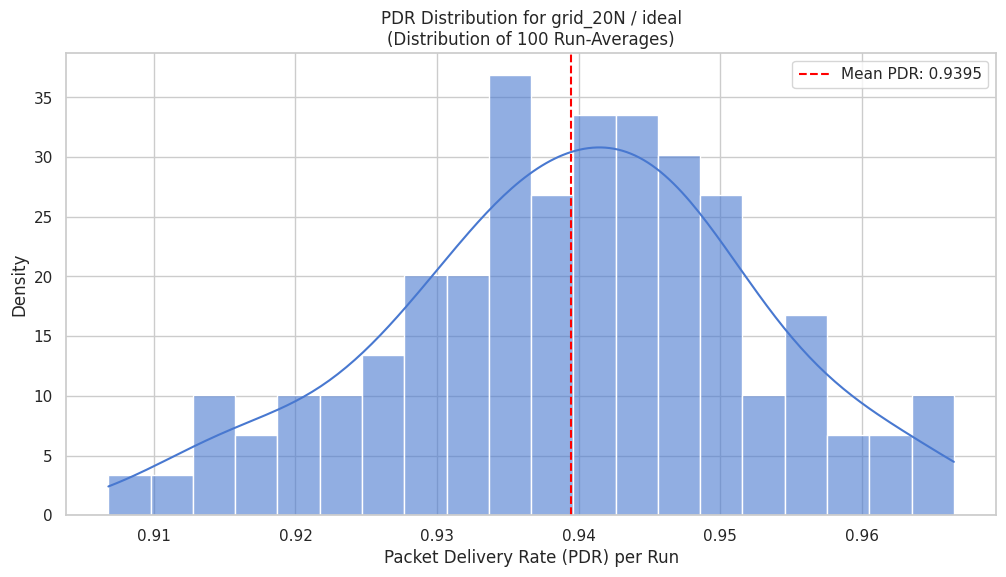


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0068 s
  Std. Dev. of Latency (all packets): 0.0031 s
  (Based on 67010 total packets delivered across all runs)


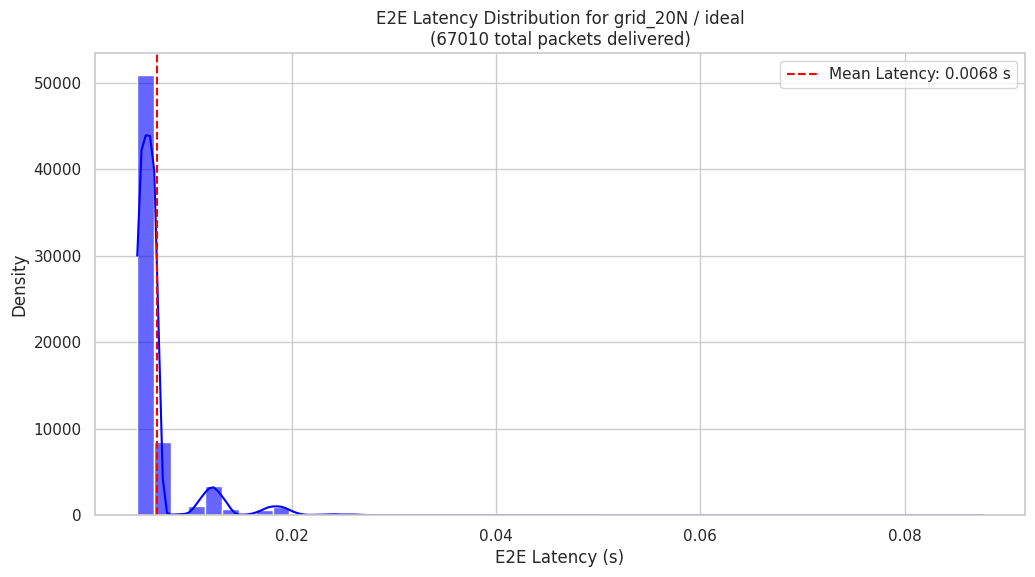



Processing Configuration: grid_20N / lossy
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9399
  Std. Dev. of PDR (run-to-run): 0.0157
  (Based on 100 simulation runs)


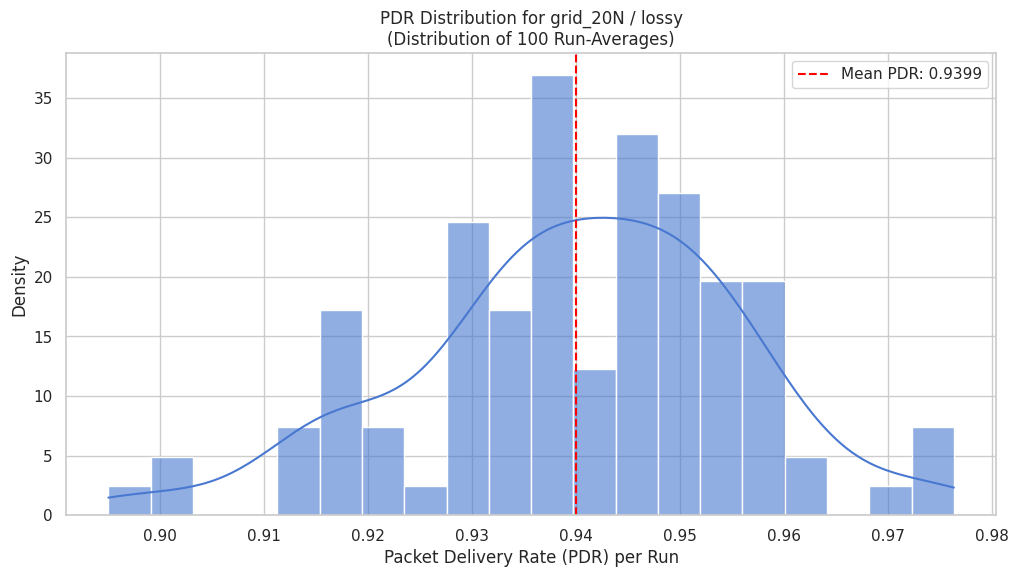


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0072 s
  Std. Dev. of Latency (all packets): 0.0041 s
  (Based on 67014 total packets delivered across all runs)


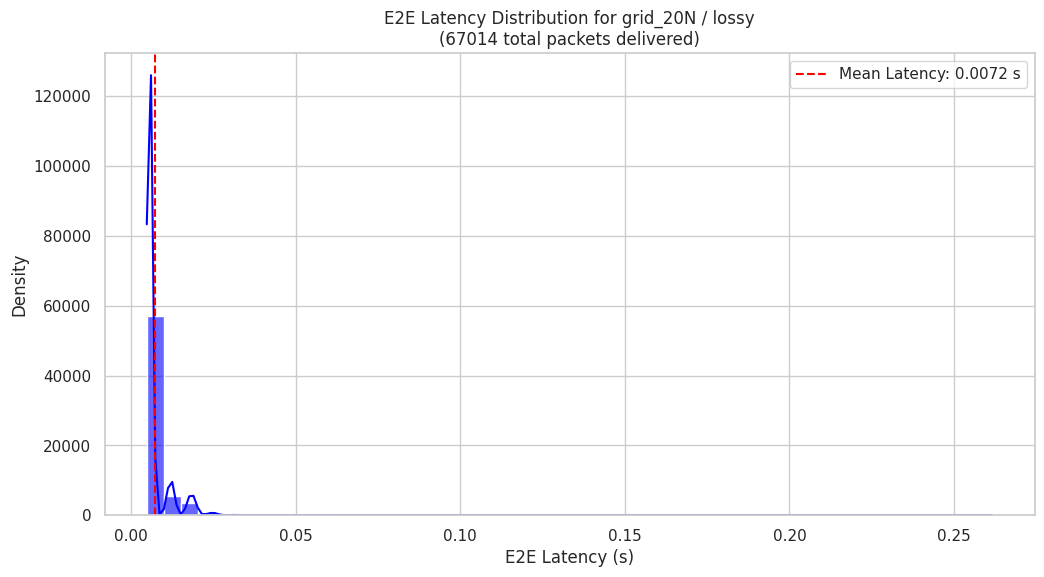



Processing Configuration: grid_20N / stable
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9393
  Std. Dev. of PDR (run-to-run): 0.0138
  (Based on 100 simulation runs)


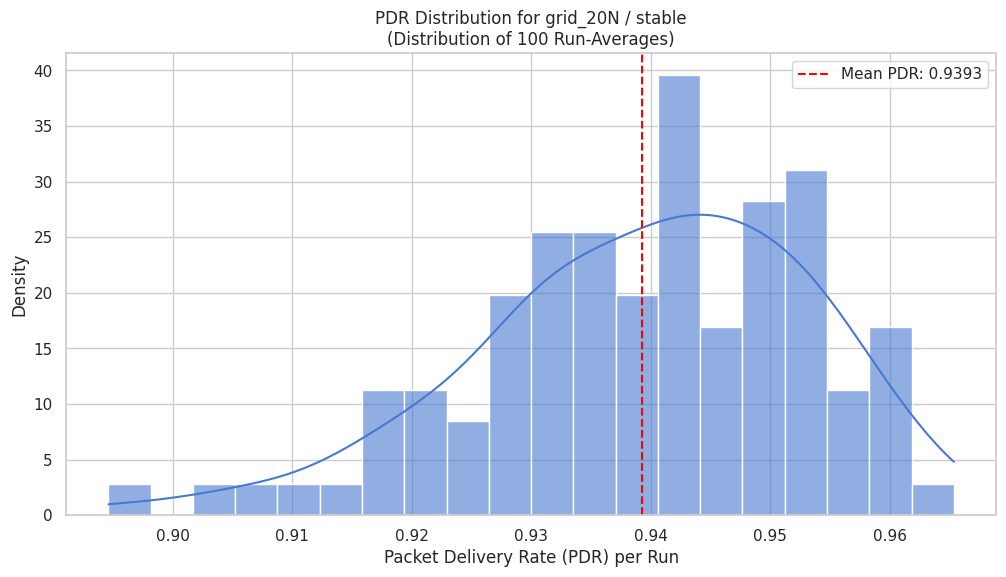


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0068 s
  Std. Dev. of Latency (all packets): 0.0032 s
  (Based on 66989 total packets delivered across all runs)


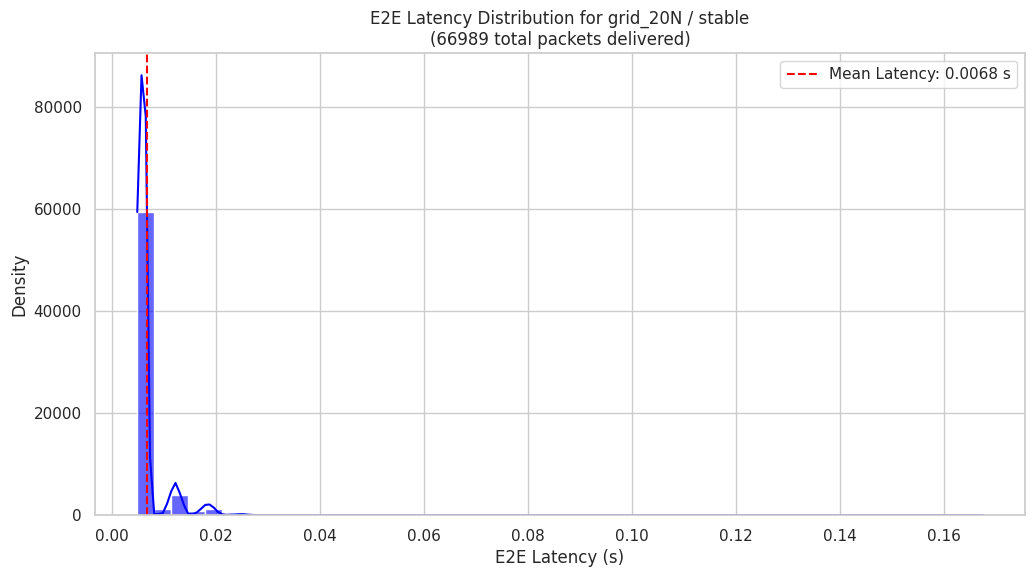



Processing Configuration: grid_20N / stable_high_pl
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9552
  Std. Dev. of PDR (run-to-run): 0.0141
  (Based on 100 simulation runs)


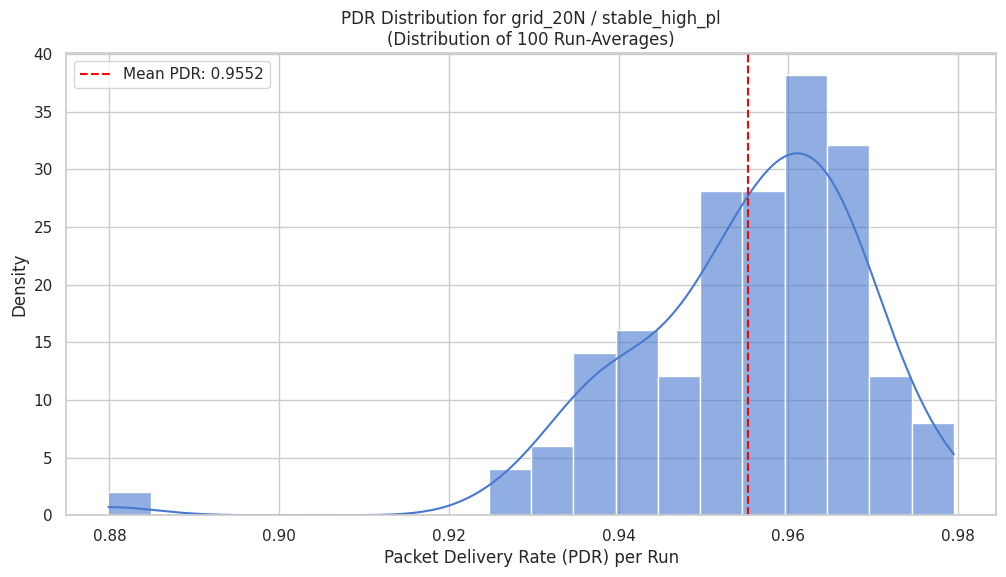


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0095 s
  Std. Dev. of Latency (all packets): 0.0062 s
  (Based on 67958 total packets delivered across all runs)


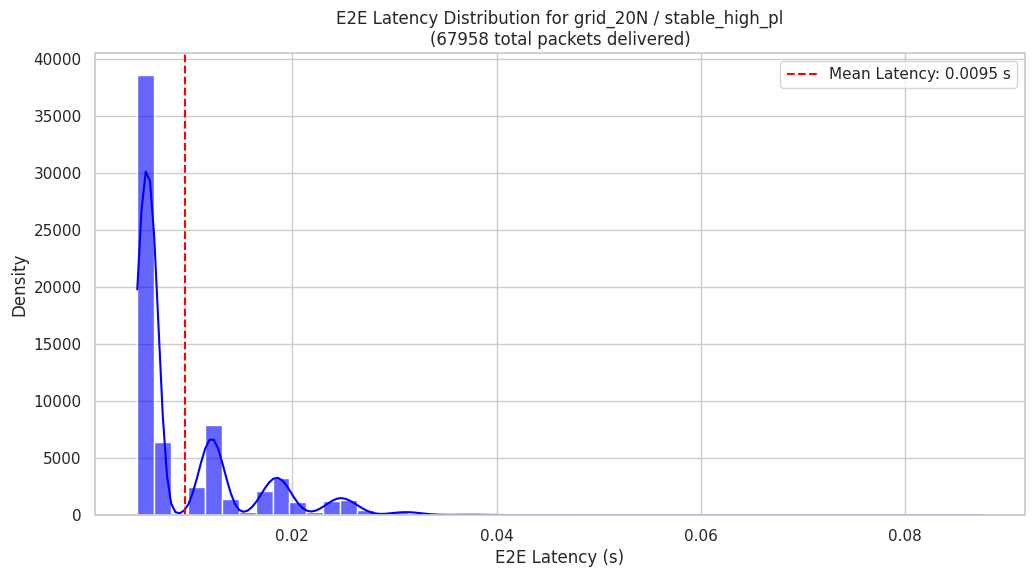



Processing Configuration: grid_20N / stable_mid_pl
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9413
  Std. Dev. of PDR (run-to-run): 0.0124
  (Based on 100 simulation runs)


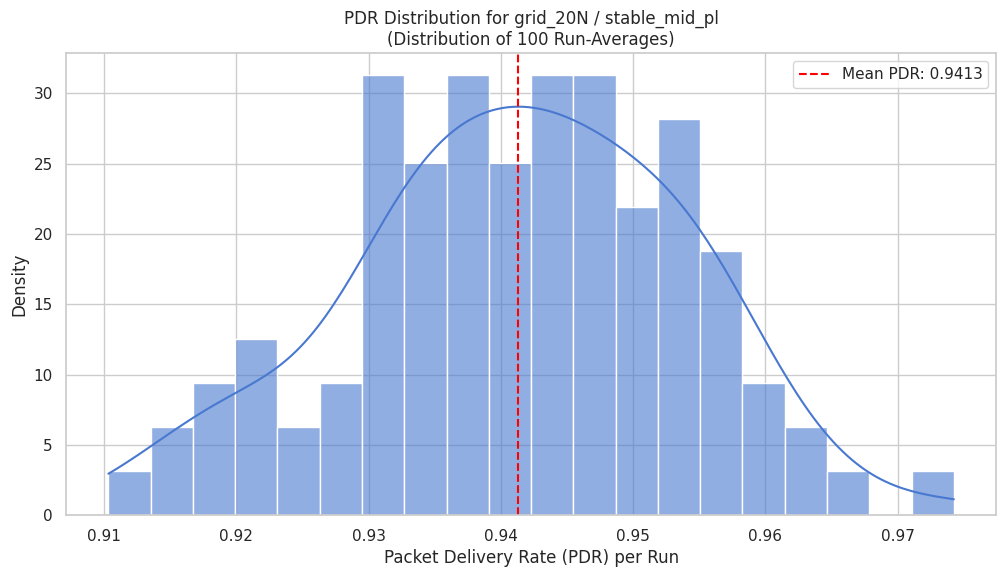


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0069 s
  Std. Dev. of Latency (all packets): 0.0033 s
  (Based on 67137 total packets delivered across all runs)


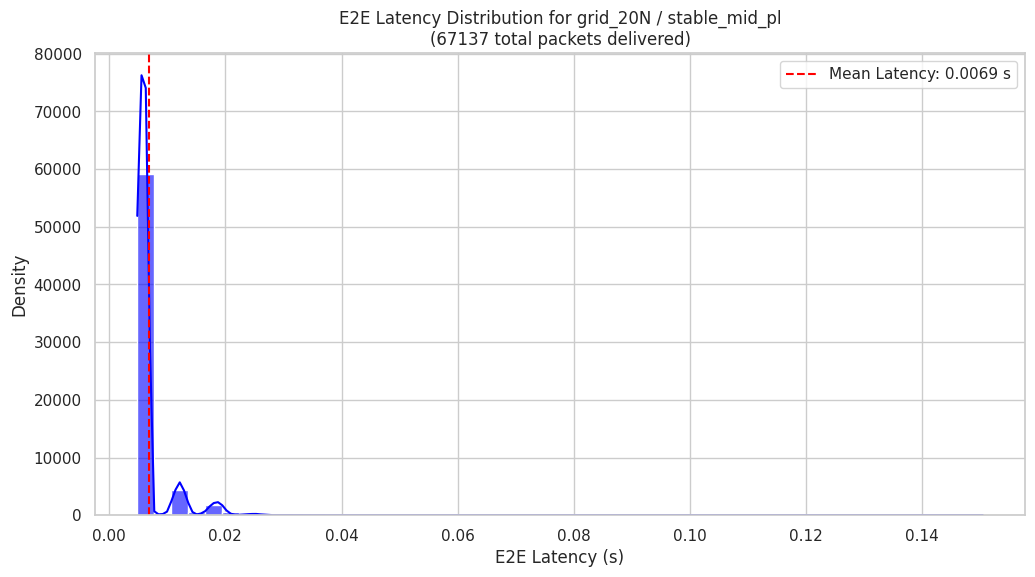



Processing Configuration: grid_20N / unstable
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9038
  Std. Dev. of PDR (run-to-run): 0.0251
  (Based on 100 simulation runs)


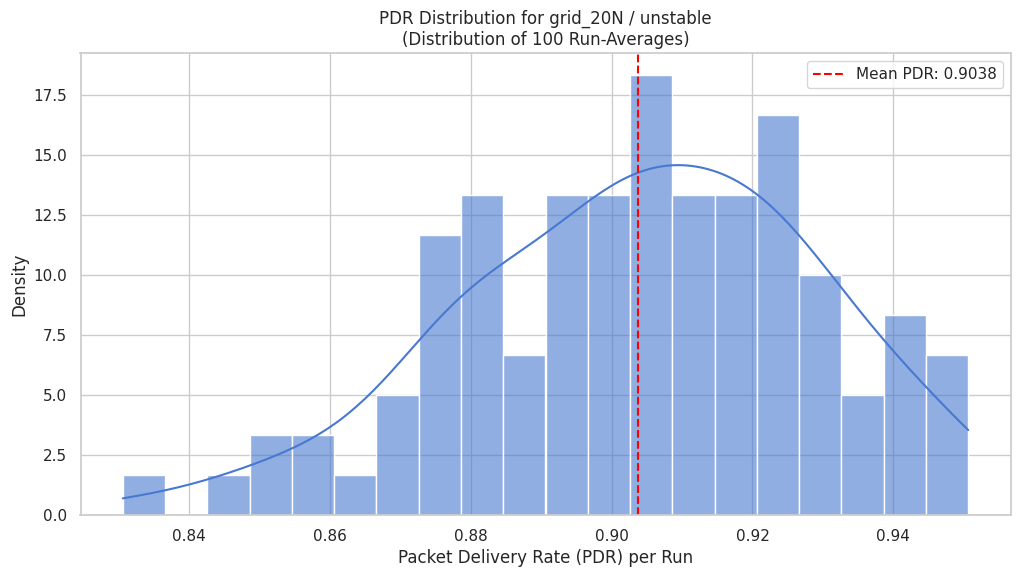


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0117 s
  Std. Dev. of Latency (all packets): 0.0093 s
  (Based on 64170 total packets delivered across all runs)


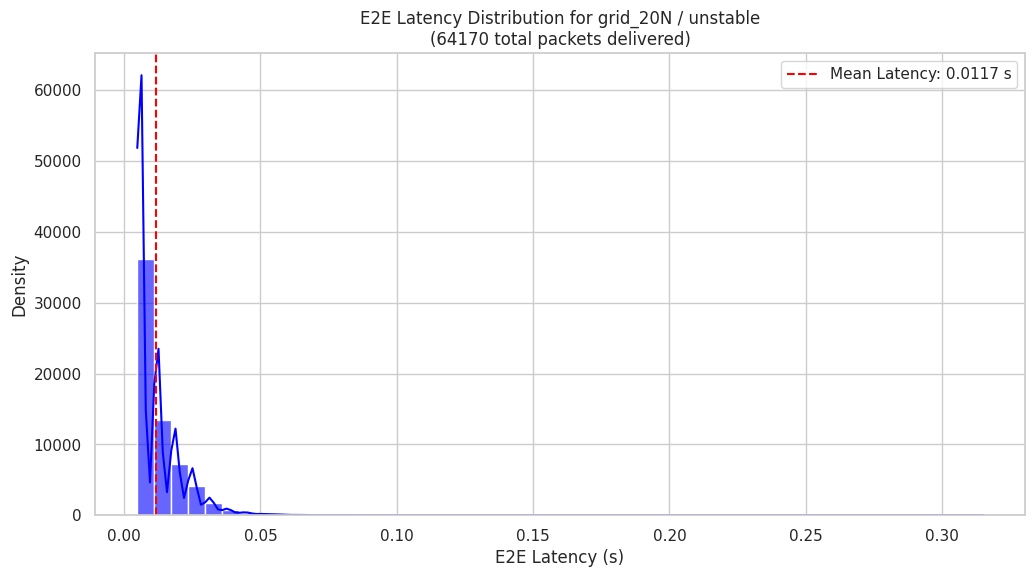



Analysis complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

# =============================================================================
# --- Configuration ---
# =============================================================================


# 1. Set this to the parent directory containing your topology folders
#    (e.g., the 'poisson_traffic' folder that holds 'random_20nodes')
PATH_TO_RESULTS_PARENT_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57")

# 2. Set this to the specific topology folder you want to analyze
#    (e.g., "random_20nodes" or "cluster-tree_20nodes")
TOPOLOGY_FOLDER_TO_ANALYZE = "grid_20N"

# --- End of Configuration ---


# Log file names (as defined in run_simulation.py and monitors)
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

# Set plot style for better aesthetics
sns.set(style="whitegrid", palette="muted")
# Suppress warnings from seaborn when data is missing for KDE
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# =============================================================================
# --- Helper Functions ---
# =============================================================================

def process_pdr_file(file_path):
    """
    Reads a single PDR log file from one run (seed).
    Calculates the PDR for that run (which is the mean of the 'delivered' column).
    Returns the PDR value (float) or None if the file is invalid.
    """
    try:
        # Load the CSV. We use skipinitialspace to handle
        # the potential leading space in the header row.
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:
            print(f"  - WARNING: PDR file is empty, skipping: {file_path}", file=sys.stderr)
            return None
        
        #
        # The 'delivered' column is 0 or 1. The mean of this column
        # is the Packet Delivery Rate for this simulation run.
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        # This is not an error, it just means the simulation run failed to
        # produce this file. We will report it and skip it.
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        print(f"  - WARNING: PDR file is empty (EmptyDataError), skipping: {file_path}", file=sys.stderr)
        return None
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None

def process_latency_file(file_path):
    """
    Reads a single E2E Latency log file from one run (seed).
    Returns a list of all individual packet latencies from that run.
    Returns an empty list if the file is invalid or no packets were delivered.
    """
    try:
        #
        # The 'latency' column contains the E2E latency for each received packet.
        df_lat = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_lat.empty:
            # This is not an error; it just means PDR was 0.
            return []
        
        if 'latency' not in df_lat.columns:
            print(f"  - ERROR: 'latency' column not found in: {file_path}", file=sys.stderr)
            return []
            
        # Return all latencies from this run
        return df_lat['latency'].tolist()
        
    except FileNotFoundError:
        # This is expected if PDR was 0 for the run.
        return [] 
    except pd.errors.EmptyDataError:
        # This is also expected if PDR was 0.
        return []
    except Exception as e:
        print(f"  - ERROR processing Latency file {file_path}: {e}", file=sys.stderr)
        return []

# =============================================================================
# --- Main Analysis Script ---
# =============================================================================

# Construct the full path to the specific topology folder we want to analyze
analysis_base_path = PATH_TO_RESULTS_PARENT_FOLDER / TOPOLOGY_FOLDER_TO_ANALYZE

if not analysis_base_path.is_dir():
    print(f"ERROR: Analysis directory not found at: {analysis_base_path}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_PARENT_FOLDER' and 'TOPOLOGY_FOLDER_TO_ANALYZE' variables.", file=sys.stderr)
else:
    print(f"Starting analysis for topology: {TOPOLOGY_FOLDER_TO_ANALYZE}\n")
    
    # Find channel folders (e.g., 'stable', 'lossy', 'unstable')
    channel_dirs = sorted([d for d in analysis_base_path.iterdir() if d.is_dir()])
    
    if not channel_dirs:
        print(f"  No channel folders (e.g., 'stable', 'lossy') found in {analysis_base_path}", file=sys.stderr)

    # --- Iterate over each Channel Configuration ---
    for channel_dir in channel_dirs:
        config_name = f"{TOPOLOGY_FOLDER_TO_ANALYZE} / {channel_dir.name}"
        print("="*70)
        print(f"Processing Configuration: {config_name}")
        print("="*70)

        # Find all replication runs (seed folders) for this configuration
        seed_dirs = sorted([d for d in channel_dir.iterdir() if d.is_dir()])
        
        if not seed_dirs:
            print(f"  No simulation runs (seed folders) found in {channel_dir}.\n")
            continue

        # These lists will store the metrics
        all_run_pdrs = []
        all_packet_latencies = []
        
        print(f"  Found {len(seed_dirs)} simulation runs (seeds). Processing...")
        valid_pdr_runs = 0
        valid_latency_runs = 0

        # --- Iterate over each Run (Seed) ---
        for seed_dir in seed_dirs:
            # --- PDR Processing ---
            pdr_file = seed_dir / PDR_LOG_FILE
            run_pdr = process_pdr_file(pdr_file)
            if run_pdr is not None:
                all_run_pdrs.append(run_pdr)
                valid_pdr_runs += 1

            # --- Latency Processing ---
            latency_file = seed_dir / LATENCY_LOG_FILE
            run_latencies = process_latency_file(latency_file)
            if run_latencies:
                all_packet_latencies.extend(run_latencies)
                valid_latency_runs += 1
        
        print(f"  Processed {len(seed_dirs)} runs: Found {valid_pdr_runs} valid PDR logs and {valid_latency_runs} valid Latency logs.")


        # --- Analyze and Plot PDR ---
        if not all_run_pdrs:
            print("\n  No valid PDR data found for this configuration.")
        else:
            pdr_array = np.array(all_run_pdrs)
            mean_pdr = np.mean(pdr_array)
            std_pdr = np.std(pdr_array)
            
            print("\n--- PDR Results ---")
            print(f"  Mean PDR (averaged over runs): {mean_pdr:.4f}")
            print(f"  Std. Dev. of PDR (run-to-run): {std_pdr:.4f}")
            print(f"  (Based on {len(pdr_array)} simulation runs)")

            # Plot PDR Distribution
            plt.figure(figsize=(12, 6))
            ax_pdr = sns.histplot(pdr_array, kde=True, bins=max(10, len(pdr_array)//5), stat="density", alpha=0.6)
            ax_pdr.axvline(mean_pdr, color='red', linestyle='--', 
                           label=f'Mean PDR: {mean_pdr:.4f}')
            
            ax_pdr.set_title(f'PDR Distribution for {config_name}\n(Distribution of {len(pdr_array)} Run-Averages)')
            ax_pdr.set_xlabel('Packet Delivery Rate (PDR) per Run')
            ax_pdr.set_ylabel('Density')
            ax_pdr.legend()
            plt.show() # Display the plot in Jupyter

        # --- Analyze and Plot Latency ---
        if not all_packet_latencies:
            print("\n  No Latency data found for this configuration (no packets were delivered).")
        else:
            latency_array = np.array(all_packet_latencies)
            mean_latency = np.mean(latency_array)
            std_latency = np.std(latency_array)
            
            print("\n--- E2E Latency Results ---")
            print(f"  Mean Latency (averaged over all packets): {mean_latency:.4f} s")
            print(f"  Std. Dev. of Latency (all packets): {std_latency:.4f} s")
            print(f"  (Based on {len(latency_array)} total packets delivered across all runs)")

            # Plot Latency Distribution
            plt.figure(figsize=(12, 6))
            
            # Check for wide variance to decide on log scale
            min_lat = np.min(latency_array)
            max_lat = np.max(latency_array)
            # Add epsilon (1e-9) to avoid division by zero if min_lat is 0
            #use_log_scale = (max_lat / (min_lat + 1e-9)) > 100
            use_log_scale = False

            # *** FIX IS HERE ***
            # 1. Create the plot and get the axes object
            ax_lat = sns.histplot(latency_array, kde=True, bins=50, alpha=0.6,
                                  color='blue' if not use_log_scale else 'purple')
            
            # 2. Add the vertical line
            ax_lat.axvline(mean_latency, color='red', linestyle='--', 
                           label=f'Mean Latency: {mean_latency:.4f} s')
            
            title = f'E2E Latency Distribution for {config_name}\n({len(latency_array)} total packets delivered)'
            xlabel = 'E2E Latency (s)'
            
            # 3. Apply log scale using matplotlib directly, which avoids the error
            if use_log_scale:
                ax_lat.set_xscale('log')
                xlabel += ' [Scale]'
                
            ax_lat.set_title(title)
            ax_lat.set_xlabel(xlabel)
            ax_lat.set_ylabel('Density')
            ax_lat.legend()
            plt.show() # Display the plot in Jupyter
            
        print("\n")

print("="*70)
print("Analysis complete.")

Starting analysis for topology: ring_20N

Processing Configuration: ring_20N / ideal
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9675
  Std. Dev. of PDR (run-to-run): 0.0097
  (Based on 100 simulation runs)


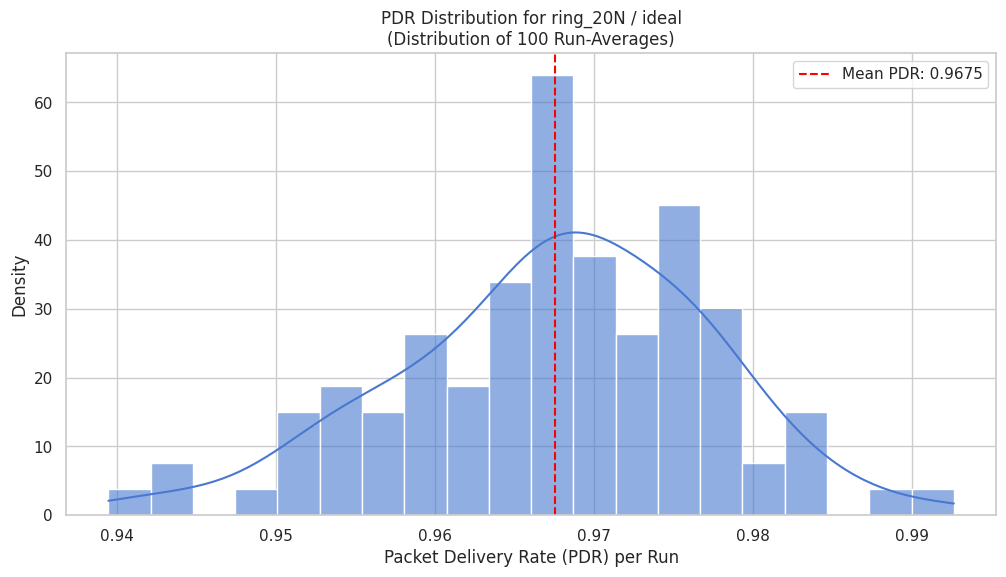


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0065 s
  Std. Dev. of Latency (all packets): 0.0026 s
  (Based on 55132 total packets delivered across all runs)


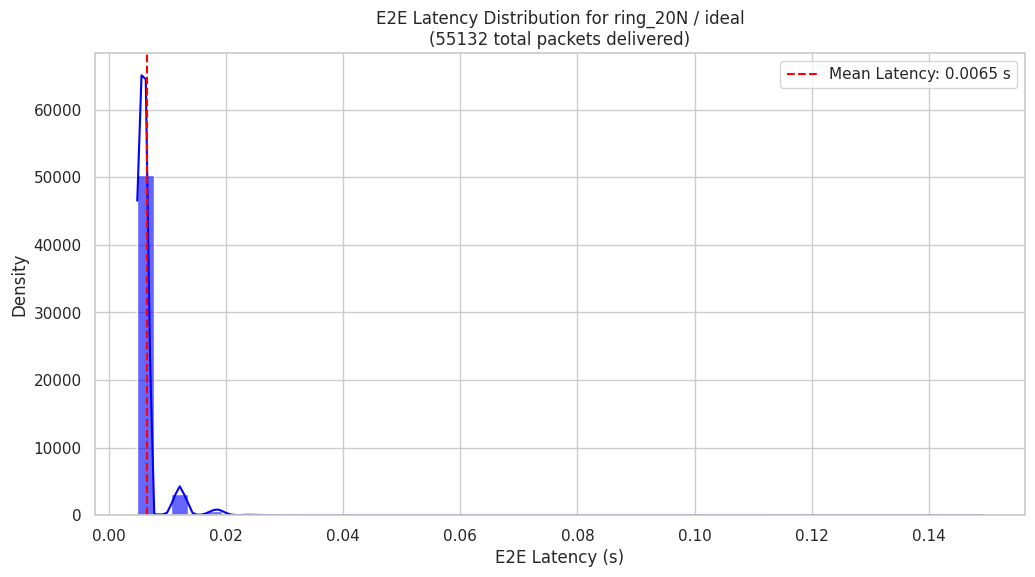



Processing Configuration: ring_20N / lossy
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9407
  Std. Dev. of PDR (run-to-run): 0.0233
  (Based on 100 simulation runs)


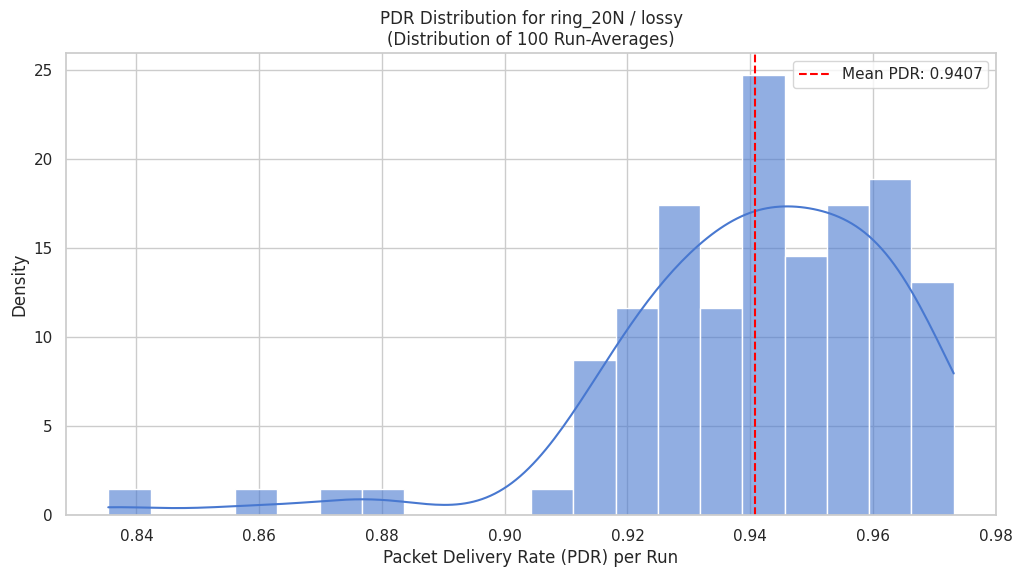


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0110 s
  Std. Dev. of Latency (all packets): 0.0073 s
  (Based on 53473 total packets delivered across all runs)


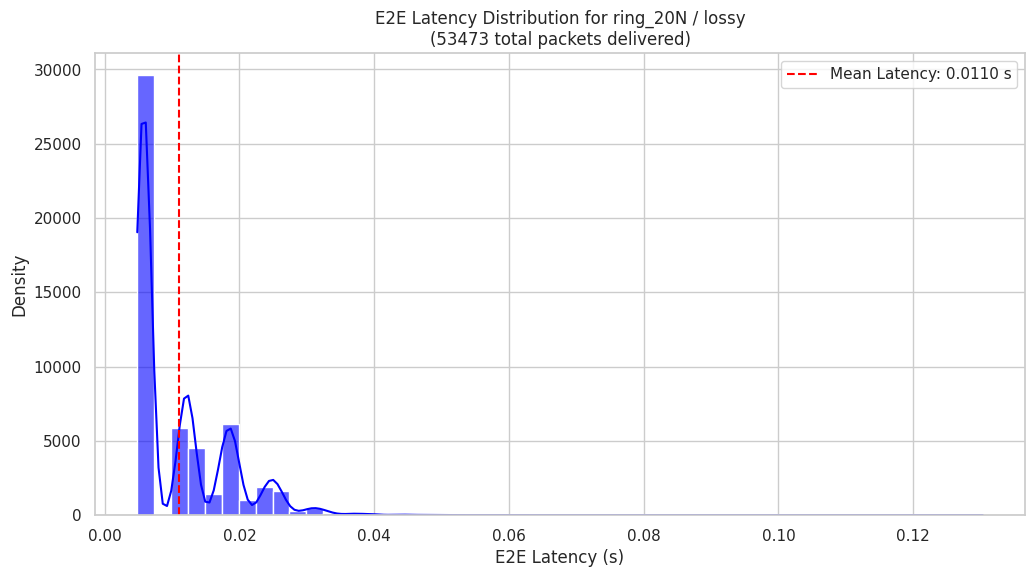



Processing Configuration: ring_20N / stable
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9682
  Std. Dev. of PDR (run-to-run): 0.0107
  (Based on 100 simulation runs)


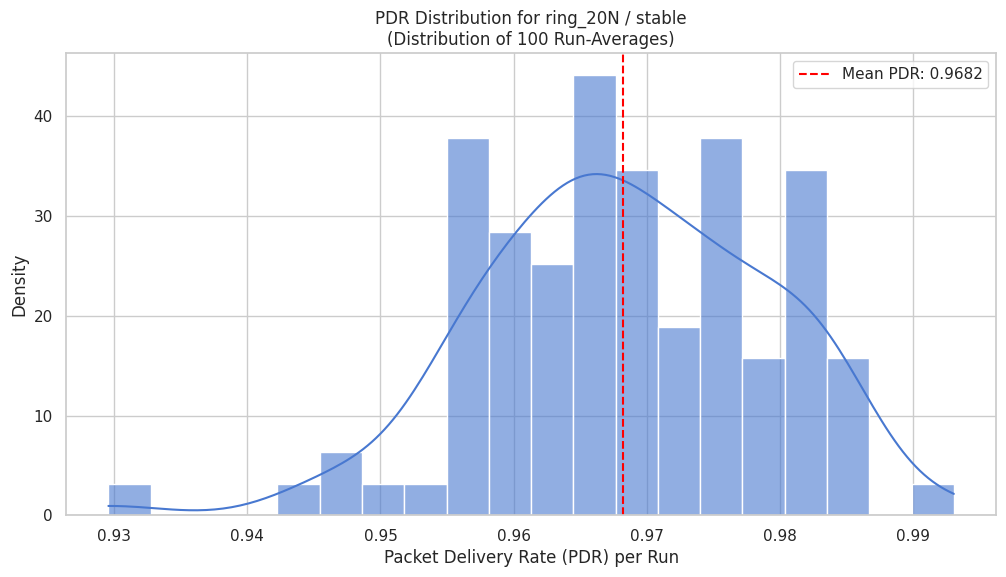


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0065 s
  Std. Dev. of Latency (all packets): 0.0028 s
  (Based on 55177 total packets delivered across all runs)


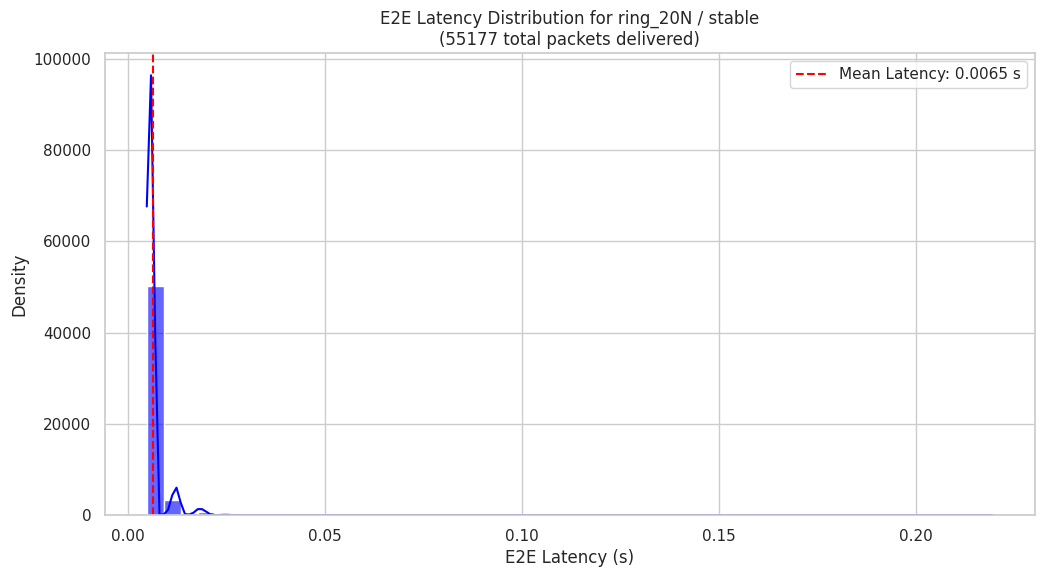



Processing Configuration: ring_20N / stable_high_pl
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.6341
  Std. Dev. of PDR (run-to-run): 0.0574
  (Based on 100 simulation runs)


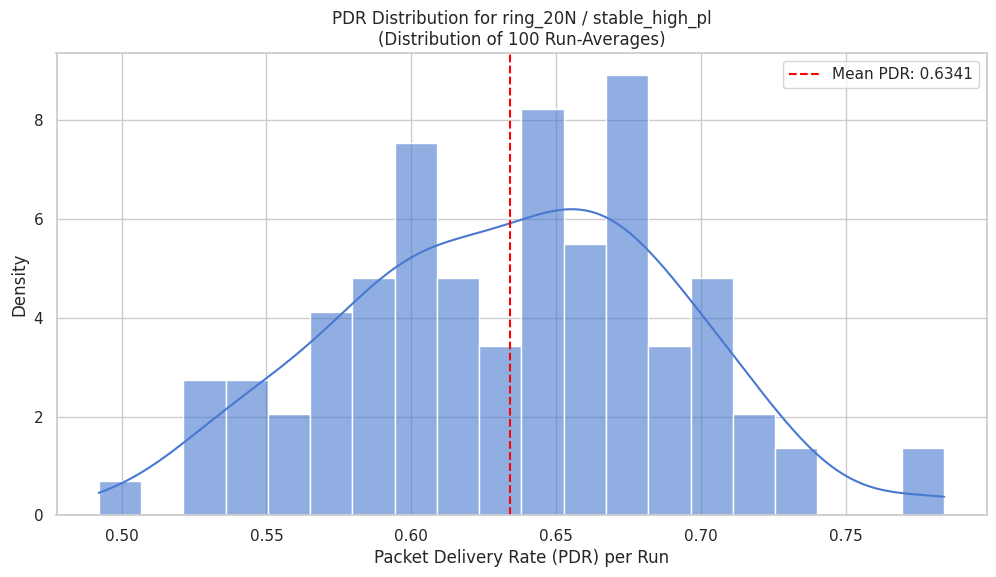


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0262 s
  Std. Dev. of Latency (all packets): 0.0192 s
  (Based on 35421 total packets delivered across all runs)


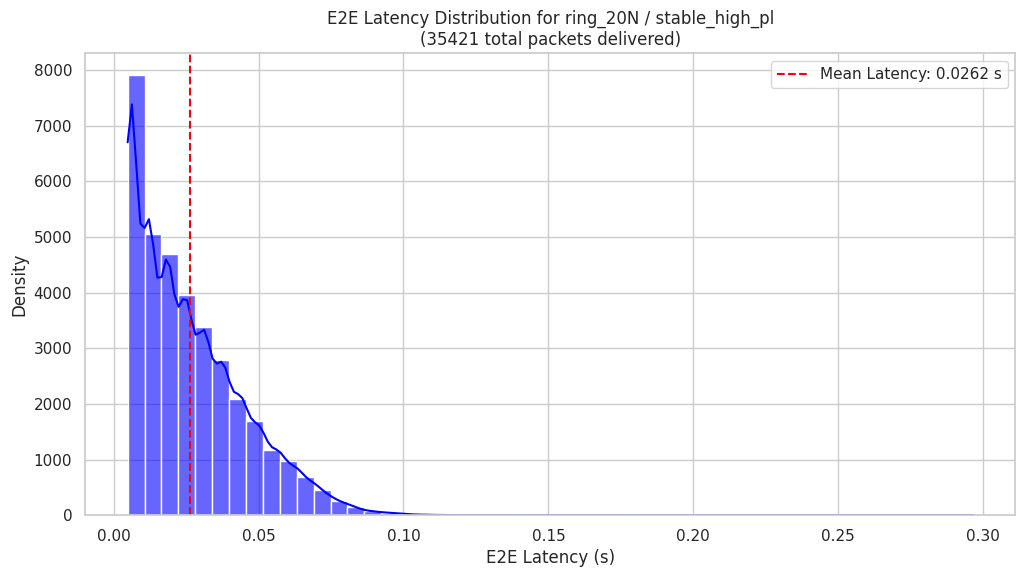



Processing Configuration: ring_20N / stable_mid_pl
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9496
  Std. Dev. of PDR (run-to-run): 0.0188
  (Based on 100 simulation runs)


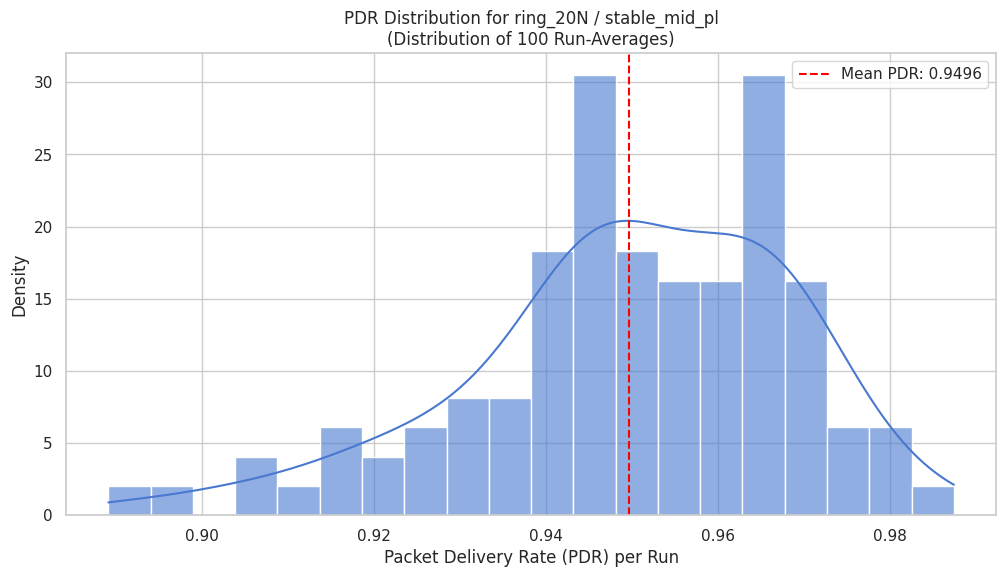


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0108 s
  Std. Dev. of Latency (all packets): 0.0071 s
  (Based on 54005 total packets delivered across all runs)


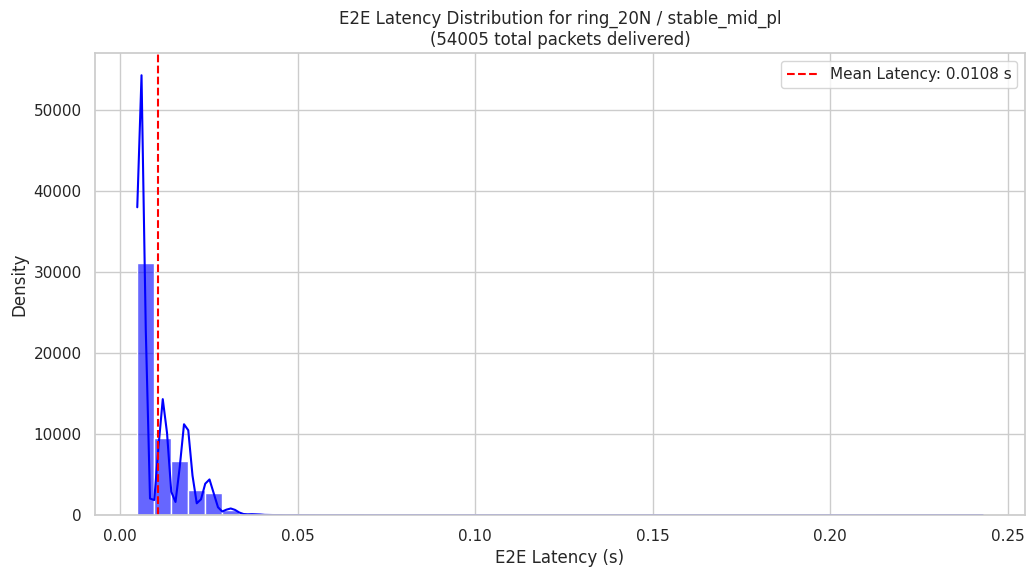



Processing Configuration: ring_20N / unstable
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.5346
  Std. Dev. of PDR (run-to-run): 0.0663
  (Based on 100 simulation runs)


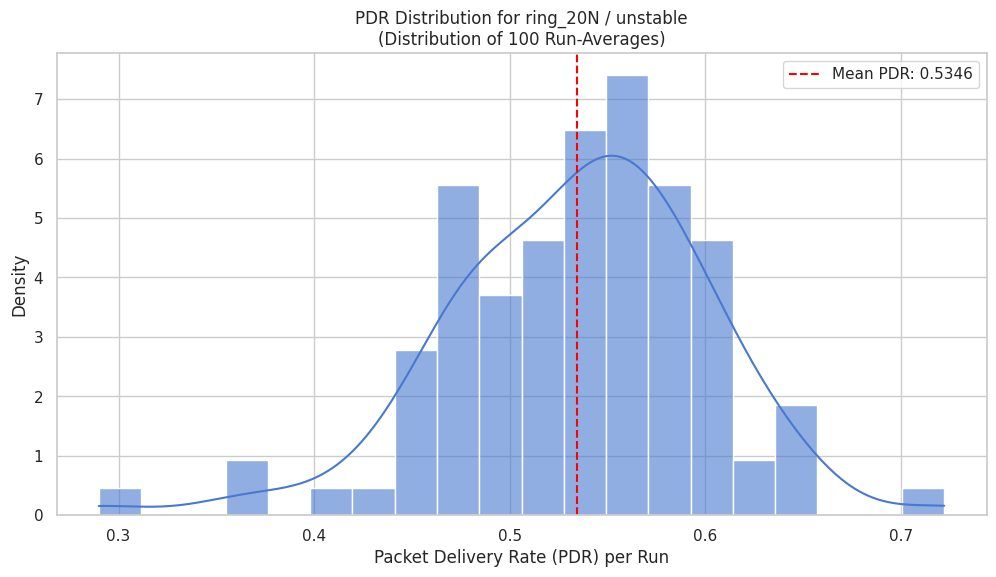


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0250 s
  Std. Dev. of Latency (all packets): 0.0214 s
  (Based on 28522 total packets delivered across all runs)


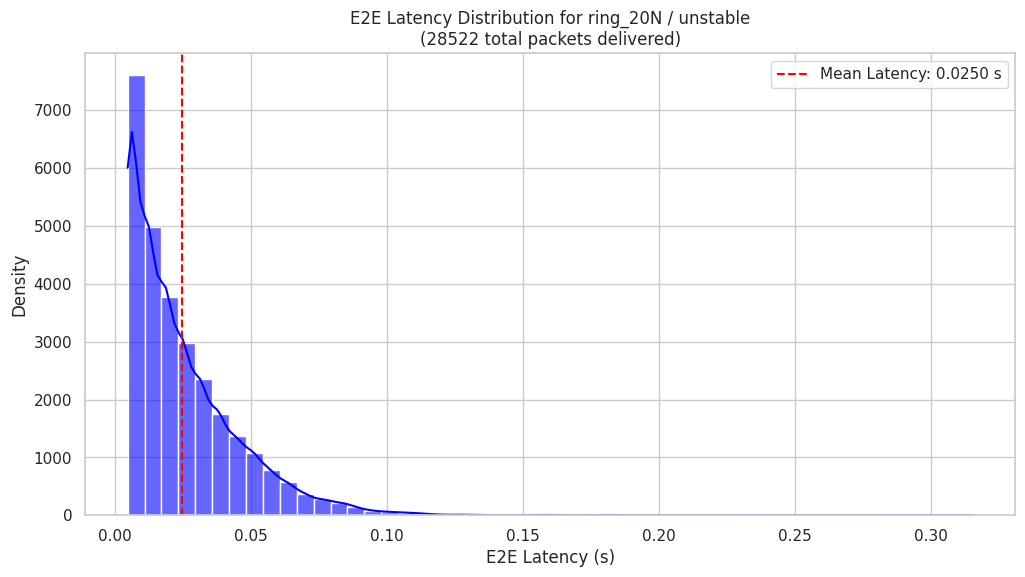



Analysis complete.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

# =============================================================================
# --- Configuration ---
# =============================================================================


# 1. Set this to the parent directory containing your topology folders
#    (e.g., the 'poisson_traffic' folder that holds 'random_20nodes')
PATH_TO_RESULTS_PARENT_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57")

# 2. Set this to the specific topology folder you want to analyze
#    (e.g., "random_20nodes" or "cluster-tree_20nodes")
TOPOLOGY_FOLDER_TO_ANALYZE = "ring_20N"

# --- End of Configuration ---


# Log file names (as defined in run_simulation.py and monitors)
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

# Set plot style for better aesthetics
sns.set(style="whitegrid", palette="muted")
# Suppress warnings from seaborn when data is missing for KDE
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# =============================================================================
# --- Helper Functions ---
# =============================================================================

def process_pdr_file(file_path):
    """
    Reads a single PDR log file from one run (seed).
    Calculates the PDR for that run (which is the mean of the 'delivered' column).
    Returns the PDR value (float) or None if the file is invalid.
    """
    try:
        # Load the CSV. We use skipinitialspace to handle
        # the potential leading space in the header row.
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:
            print(f"  - WARNING: PDR file is empty, skipping: {file_path}", file=sys.stderr)
            return None
        
        #
        # The 'delivered' column is 0 or 1. The mean of this column
        # is the Packet Delivery Rate for this simulation run.
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        # This is not an error, it just means the simulation run failed to
        # produce this file. We will report it and skip it.
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        print(f"  - WARNING: PDR file is empty (EmptyDataError), skipping: {file_path}", file=sys.stderr)
        return None
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None

def process_latency_file(file_path):
    """
    Reads a single E2E Latency log file from one run (seed).
    Returns a list of all individual packet latencies from that run.
    Returns an empty list if the file is invalid or no packets were delivered.
    """
    try:
        #
        # The 'latency' column contains the E2E latency for each received packet.
        df_lat = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_lat.empty:
            # This is not an error; it just means PDR was 0.
            return []
        
        if 'latency' not in df_lat.columns:
            print(f"  - ERROR: 'latency' column not found in: {file_path}", file=sys.stderr)
            return []
            
        # Return all latencies from this run
        return df_lat['latency'].tolist()
        
    except FileNotFoundError:
        # This is expected if PDR was 0 for the run.
        return [] 
    except pd.errors.EmptyDataError:
        # This is also expected if PDR was 0.
        return []
    except Exception as e:
        print(f"  - ERROR processing Latency file {file_path}: {e}", file=sys.stderr)
        return []

# =============================================================================
# --- Main Analysis Script ---
# =============================================================================

# Construct the full path to the specific topology folder we want to analyze
analysis_base_path = PATH_TO_RESULTS_PARENT_FOLDER / TOPOLOGY_FOLDER_TO_ANALYZE

if not analysis_base_path.is_dir():
    print(f"ERROR: Analysis directory not found at: {analysis_base_path}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_PARENT_FOLDER' and 'TOPOLOGY_FOLDER_TO_ANALYZE' variables.", file=sys.stderr)
else:
    print(f"Starting analysis for topology: {TOPOLOGY_FOLDER_TO_ANALYZE}\n")
    
    # Find channel folders (e.g., 'stable', 'lossy', 'unstable')
    channel_dirs = sorted([d for d in analysis_base_path.iterdir() if d.is_dir()])
    
    if not channel_dirs:
        print(f"  No channel folders (e.g., 'stable', 'lossy') found in {analysis_base_path}", file=sys.stderr)

    # --- Iterate over each Channel Configuration ---
    for channel_dir in channel_dirs:
        config_name = f"{TOPOLOGY_FOLDER_TO_ANALYZE} / {channel_dir.name}"
        print("="*70)
        print(f"Processing Configuration: {config_name}")
        print("="*70)

        # Find all replication runs (seed folders) for this configuration
        seed_dirs = sorted([d for d in channel_dir.iterdir() if d.is_dir()])
        
        if not seed_dirs:
            print(f"  No simulation runs (seed folders) found in {channel_dir}.\n")
            continue

        # These lists will store the metrics
        all_run_pdrs = []
        all_packet_latencies = []
        
        print(f"  Found {len(seed_dirs)} simulation runs (seeds). Processing...")
        valid_pdr_runs = 0
        valid_latency_runs = 0

        # --- Iterate over each Run (Seed) ---
        for seed_dir in seed_dirs:
            # --- PDR Processing ---
            pdr_file = seed_dir / PDR_LOG_FILE
            run_pdr = process_pdr_file(pdr_file)
            if run_pdr is not None:
                all_run_pdrs.append(run_pdr)
                valid_pdr_runs += 1

            # --- Latency Processing ---
            latency_file = seed_dir / LATENCY_LOG_FILE
            run_latencies = process_latency_file(latency_file)
            if run_latencies:
                all_packet_latencies.extend(run_latencies)
                valid_latency_runs += 1
        
        print(f"  Processed {len(seed_dirs)} runs: Found {valid_pdr_runs} valid PDR logs and {valid_latency_runs} valid Latency logs.")


        # --- Analyze and Plot PDR ---
        if not all_run_pdrs:
            print("\n  No valid PDR data found for this configuration.")
        else:
            pdr_array = np.array(all_run_pdrs)
            mean_pdr = np.mean(pdr_array)
            std_pdr = np.std(pdr_array)
            
            print("\n--- PDR Results ---")
            print(f"  Mean PDR (averaged over runs): {mean_pdr:.4f}")
            print(f"  Std. Dev. of PDR (run-to-run): {std_pdr:.4f}")
            print(f"  (Based on {len(pdr_array)} simulation runs)")

            # Plot PDR Distribution
            plt.figure(figsize=(12, 6))
            ax_pdr = sns.histplot(pdr_array, kde=True, bins=max(10, len(pdr_array)//5), stat="density", alpha=0.6)
            ax_pdr.axvline(mean_pdr, color='red', linestyle='--', 
                           label=f'Mean PDR: {mean_pdr:.4f}')
            
            ax_pdr.set_title(f'PDR Distribution for {config_name}\n(Distribution of {len(pdr_array)} Run-Averages)')
            ax_pdr.set_xlabel('Packet Delivery Rate (PDR) per Run')
            ax_pdr.set_ylabel('Density')
            ax_pdr.legend()
            plt.show() # Display the plot in Jupyter

        # --- Analyze and Plot Latency ---
        if not all_packet_latencies:
            print("\n  No Latency data found for this configuration (no packets were delivered).")
        else:
            latency_array = np.array(all_packet_latencies)
            mean_latency = np.mean(latency_array)
            std_latency = np.std(latency_array)
            
            print("\n--- E2E Latency Results ---")
            print(f"  Mean Latency (averaged over all packets): {mean_latency:.4f} s")
            print(f"  Std. Dev. of Latency (all packets): {std_latency:.4f} s")
            print(f"  (Based on {len(latency_array)} total packets delivered across all runs)")

            # Plot Latency Distribution
            plt.figure(figsize=(12, 6))
            
            # Check for wide variance to decide on log scale
            min_lat = np.min(latency_array)
            max_lat = np.max(latency_array)
            # Add epsilon (1e-9) to avoid division by zero if min_lat is 0
            #use_log_scale = (max_lat / (min_lat + 1e-9)) > 100
            use_log_scale = False

            # *** FIX IS HERE ***
            # 1. Create the plot and get the axes object
            ax_lat = sns.histplot(latency_array, kde=True, bins=50, alpha=0.6,
                                  color='blue' if not use_log_scale else 'purple')
            
            # 2. Add the vertical line
            ax_lat.axvline(mean_latency, color='red', linestyle='--', 
                           label=f'Mean Latency: {mean_latency:.4f} s')
            
            title = f'E2E Latency Distribution for {config_name}\n({len(latency_array)} total packets delivered)'
            xlabel = 'E2E Latency (s)'
            
            # 3. Apply log scale using matplotlib directly, which avoids the error
            if use_log_scale:
                ax_lat.set_xscale('log')
                xlabel += ' [Scale]'
                
            ax_lat.set_title(title)
            ax_lat.set_xlabel(xlabel)
            ax_lat.set_ylabel('Density')
            ax_lat.legend()
            plt.show() # Display the plot in Jupyter
            
        print("\n")

print("="*70)
print("Analysis complete.")

Starting analysis for topology: random_20N

Processing Configuration: random_20N / ideal
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9676
  Std. Dev. of PDR (run-to-run): 0.0114
  (Based on 100 simulation runs)


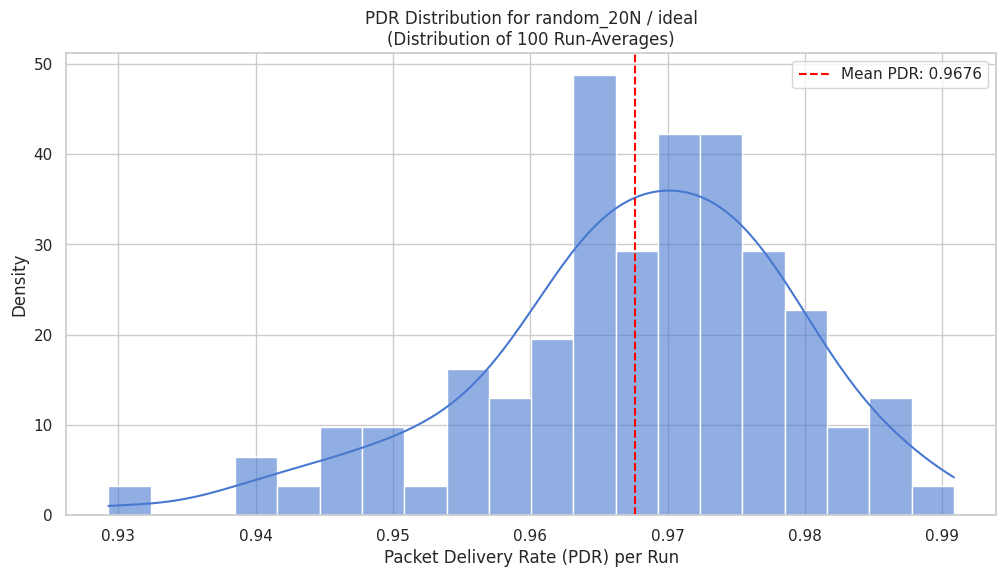


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0065 s
  Std. Dev. of Latency (all packets): 0.0025 s
  (Based on 55142 total packets delivered across all runs)


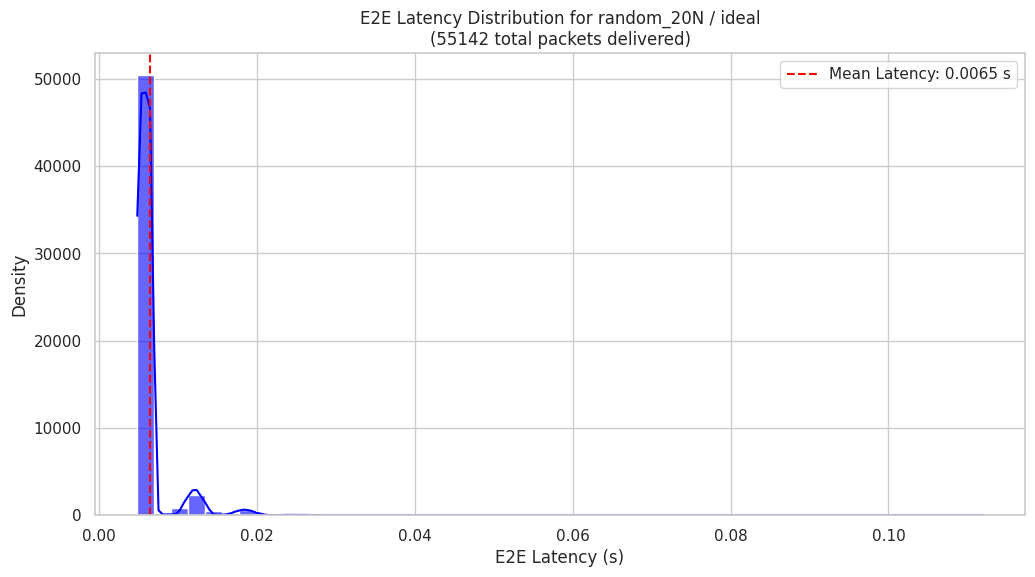



Processing Configuration: random_20N / lossy
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9352
  Std. Dev. of PDR (run-to-run): 0.0228
  (Based on 100 simulation runs)


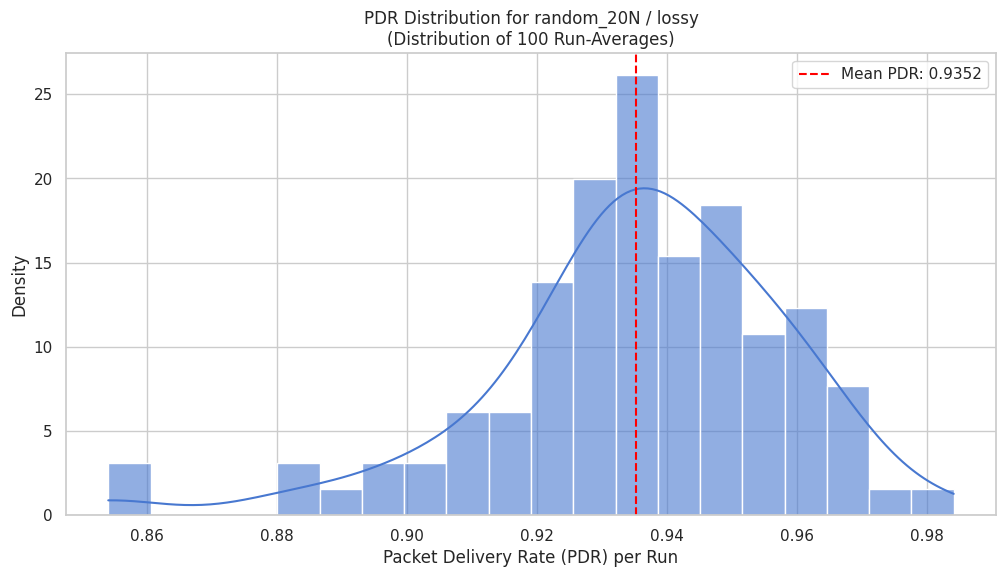


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0104 s
  Std. Dev. of Latency (all packets): 0.0067 s
  (Based on 53187 total packets delivered across all runs)


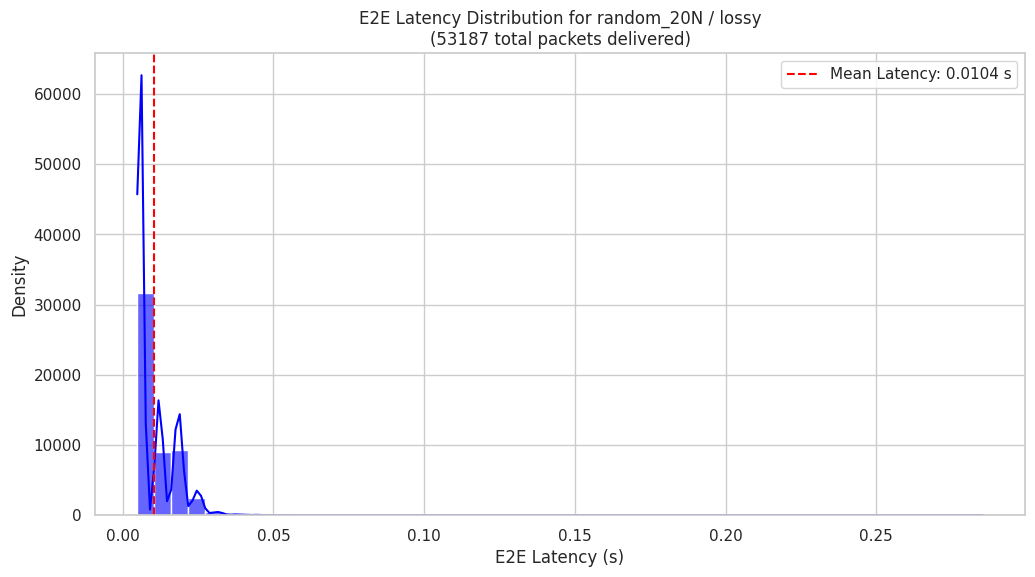



Processing Configuration: random_20N / stable
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9652
  Std. Dev. of PDR (run-to-run): 0.0121
  (Based on 100 simulation runs)


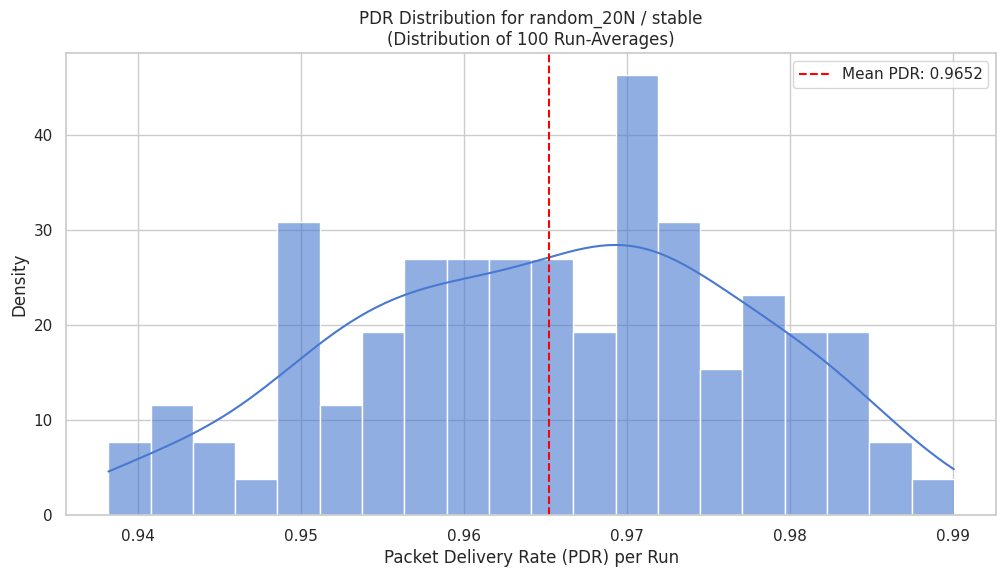


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0065 s
  Std. Dev. of Latency (all packets): 0.0026 s
  (Based on 55000 total packets delivered across all runs)


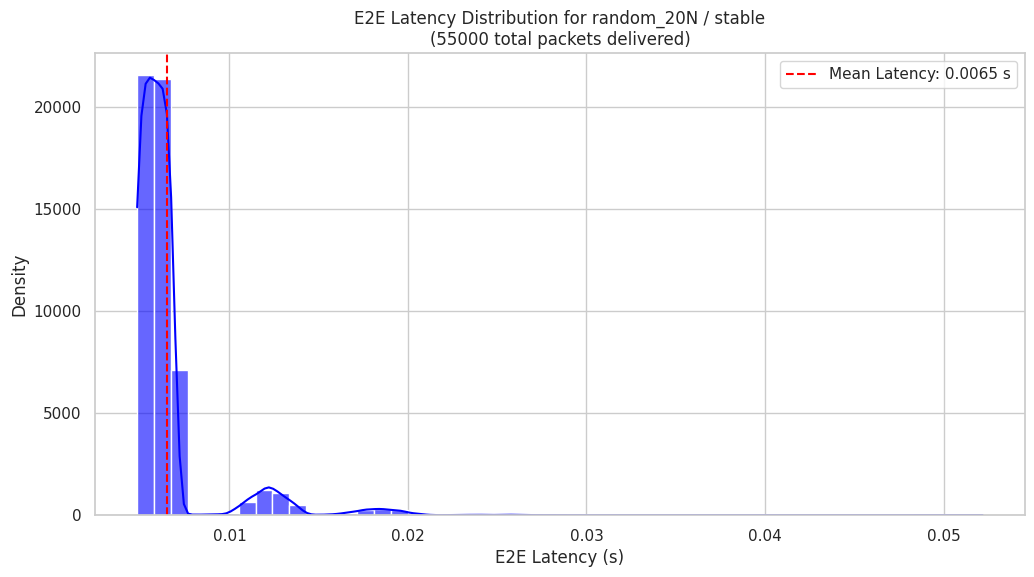



Processing Configuration: random_20N / stable_high_pl
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.7434
  Std. Dev. of PDR (run-to-run): 0.0604
  (Based on 100 simulation runs)


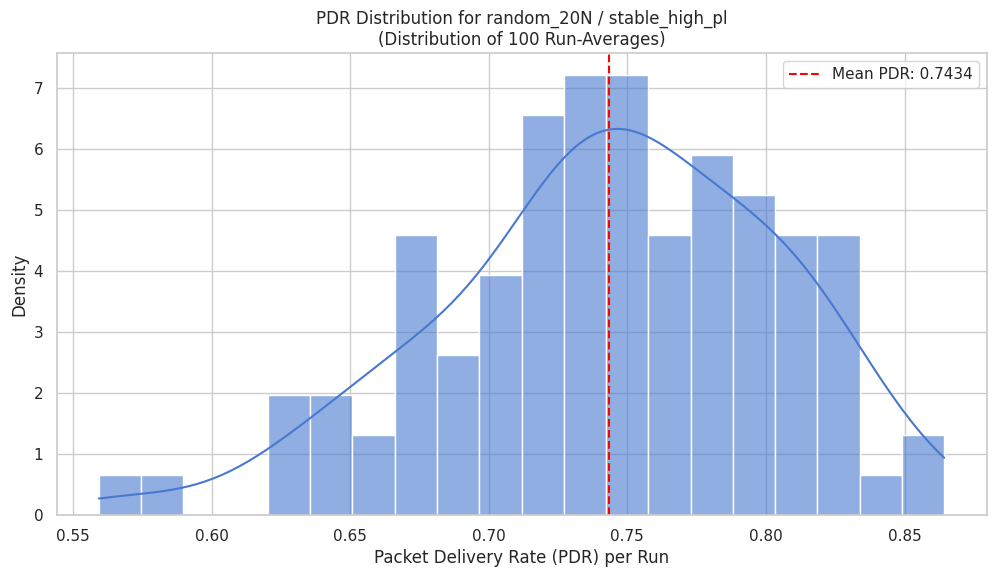


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0201 s
  Std. Dev. of Latency (all packets): 0.0125 s
  (Based on 41570 total packets delivered across all runs)


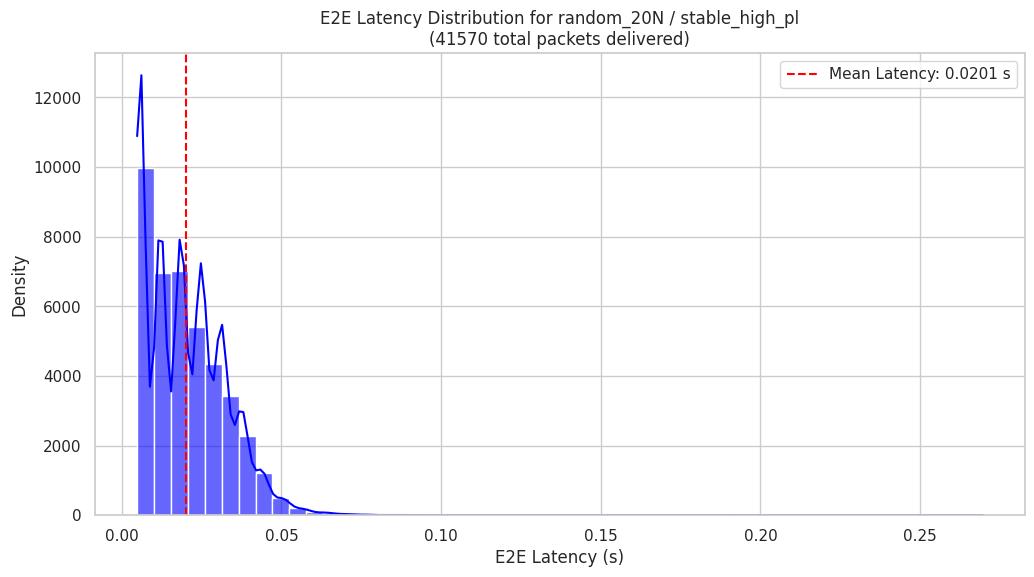



Processing Configuration: random_20N / stable_mid_pl
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9393
  Std. Dev. of PDR (run-to-run): 0.0197
  (Based on 100 simulation runs)


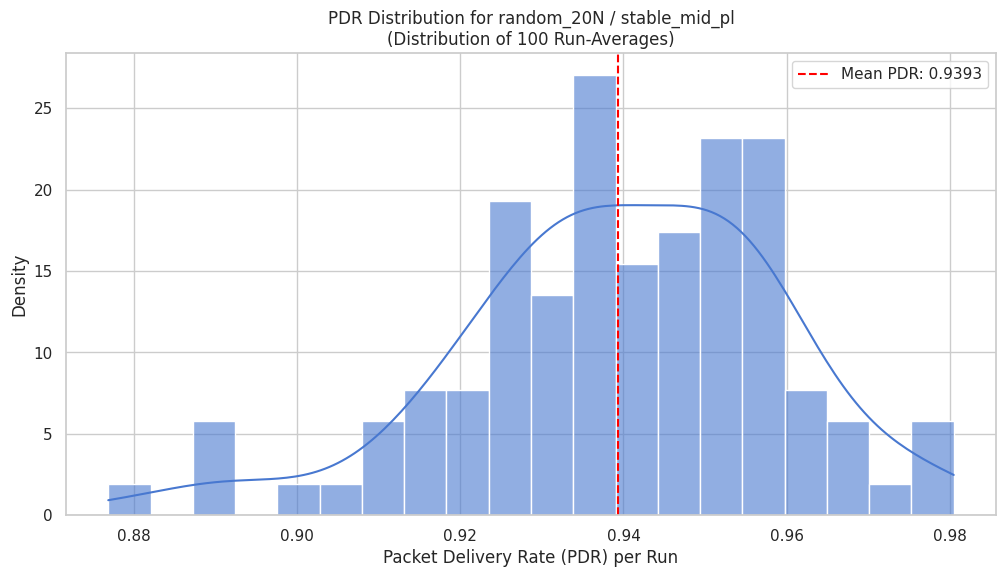


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0099 s
  Std. Dev. of Latency (all packets): 0.0061 s
  (Based on 53474 total packets delivered across all runs)


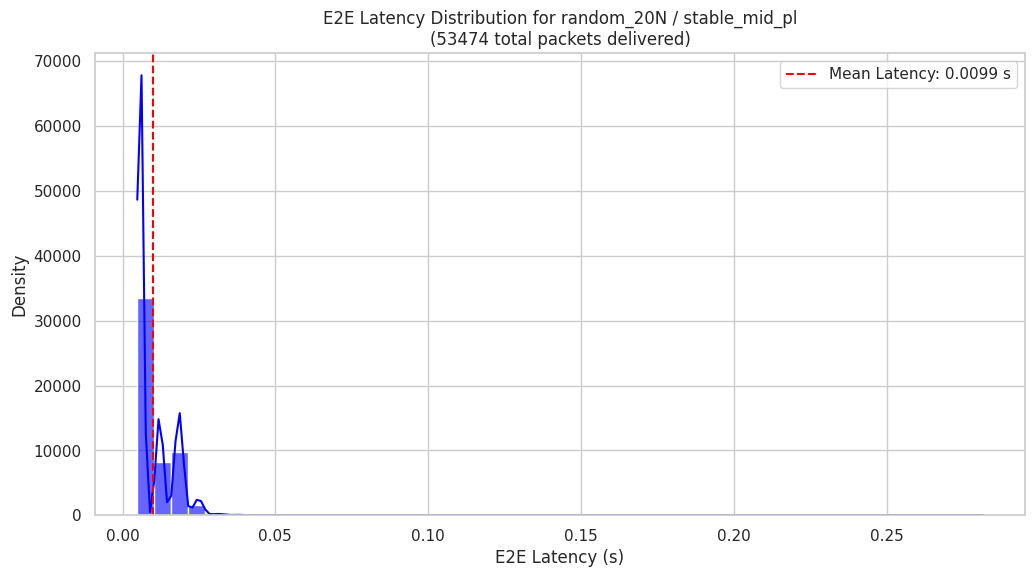



Processing Configuration: random_20N / unstable
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.6251
  Std. Dev. of PDR (run-to-run): 0.0784
  (Based on 100 simulation runs)


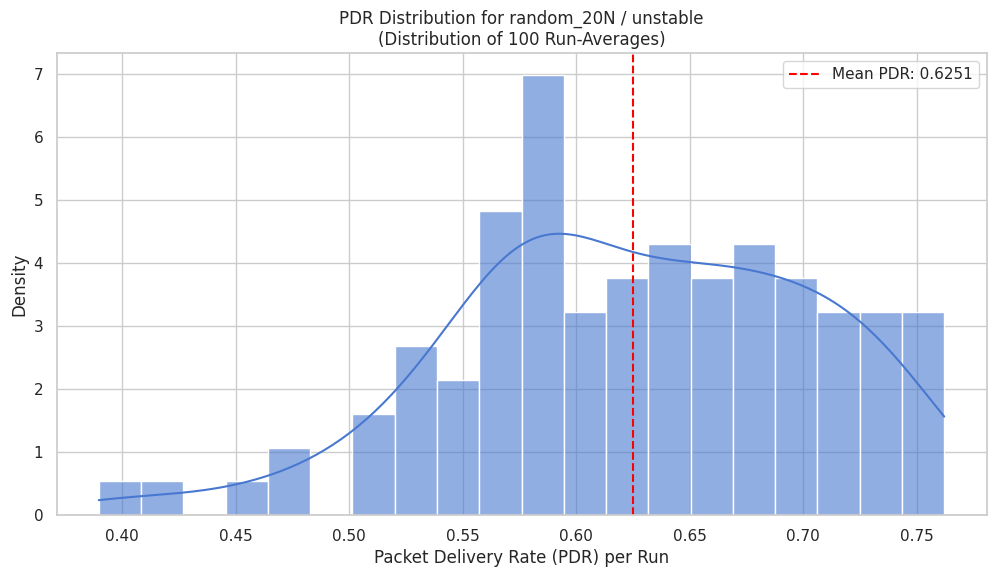


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0212 s
  Std. Dev. of Latency (all packets): 0.0170 s
  (Based on 33966 total packets delivered across all runs)


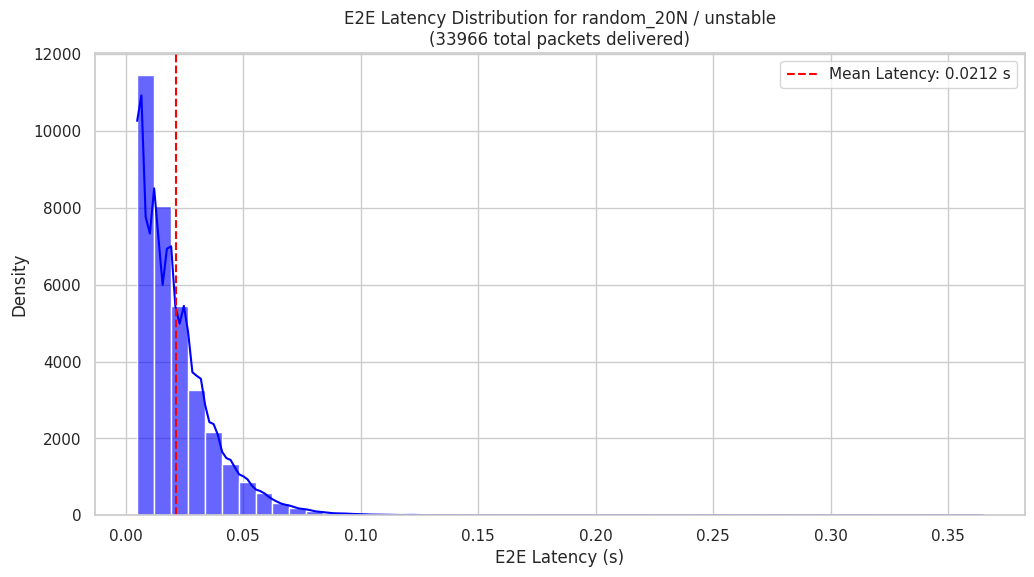



Analysis complete.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

# =============================================================================
# --- Configuration ---
# =============================================================================


# 1. Set this to the parent directory containing your topology folders
#    (e.g., the 'poisson_traffic' folder that holds 'random_20nodes')
PATH_TO_RESULTS_PARENT_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57")

# 2. Set this to the specific topology folder you want to analyze
#    (e.g., "random_20nodes" or "cluster-tree_20nodes")
TOPOLOGY_FOLDER_TO_ANALYZE = "random_20N"

# --- End of Configuration ---


# Log file names (as defined in run_simulation.py and monitors)
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

# Set plot style for better aesthetics
sns.set(style="whitegrid", palette="muted")
# Suppress warnings from seaborn when data is missing for KDE
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# =============================================================================
# --- Helper Functions ---
# =============================================================================

def process_pdr_file(file_path):
    """
    Reads a single PDR log file from one run (seed).
    Calculates the PDR for that run (which is the mean of the 'delivered' column).
    Returns the PDR value (float) or None if the file is invalid.
    """
    try:
        # Load the CSV. We use skipinitialspace to handle
        # the potential leading space in the header row.
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:
            print(f"  - WARNING: PDR file is empty, skipping: {file_path}", file=sys.stderr)
            return None
        
        #
        # The 'delivered' column is 0 or 1. The mean of this column
        # is the Packet Delivery Rate for this simulation run.
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        # This is not an error, it just means the simulation run failed to
        # produce this file. We will report it and skip it.
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        print(f"  - WARNING: PDR file is empty (EmptyDataError), skipping: {file_path}", file=sys.stderr)
        return None
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None

def process_latency_file(file_path):
    """
    Reads a single E2E Latency log file from one run (seed).
    Returns a list of all individual packet latencies from that run.
    Returns an empty list if the file is invalid or no packets were delivered.
    """
    try:
        #
        # The 'latency' column contains the E2E latency for each received packet.
        df_lat = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_lat.empty:
            # This is not an error; it just means PDR was 0.
            return []
        
        if 'latency' not in df_lat.columns:
            print(f"  - ERROR: 'latency' column not found in: {file_path}", file=sys.stderr)
            return []
            
        # Return all latencies from this run
        return df_lat['latency'].tolist()
        
    except FileNotFoundError:
        # This is expected if PDR was 0 for the run.
        return [] 
    except pd.errors.EmptyDataError:
        # This is also expected if PDR was 0.
        return []
    except Exception as e:
        print(f"  - ERROR processing Latency file {file_path}: {e}", file=sys.stderr)
        return []

# =============================================================================
# --- Main Analysis Script ---
# =============================================================================

# Construct the full path to the specific topology folder we want to analyze
analysis_base_path = PATH_TO_RESULTS_PARENT_FOLDER / TOPOLOGY_FOLDER_TO_ANALYZE

if not analysis_base_path.is_dir():
    print(f"ERROR: Analysis directory not found at: {analysis_base_path}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_PARENT_FOLDER' and 'TOPOLOGY_FOLDER_TO_ANALYZE' variables.", file=sys.stderr)
else:
    print(f"Starting analysis for topology: {TOPOLOGY_FOLDER_TO_ANALYZE}\n")
    
    # Find channel folders (e.g., 'stable', 'lossy', 'unstable')
    channel_dirs = sorted([d for d in analysis_base_path.iterdir() if d.is_dir()])
    
    if not channel_dirs:
        print(f"  No channel folders (e.g., 'stable', 'lossy') found in {analysis_base_path}", file=sys.stderr)

    # --- Iterate over each Channel Configuration ---
    for channel_dir in channel_dirs:
        config_name = f"{TOPOLOGY_FOLDER_TO_ANALYZE} / {channel_dir.name}"
        print("="*70)
        print(f"Processing Configuration: {config_name}")
        print("="*70)

        # Find all replication runs (seed folders) for this configuration
        seed_dirs = sorted([d for d in channel_dir.iterdir() if d.is_dir()])
        
        if not seed_dirs:
            print(f"  No simulation runs (seed folders) found in {channel_dir}.\n")
            continue

        # These lists will store the metrics
        all_run_pdrs = []
        all_packet_latencies = []
        
        print(f"  Found {len(seed_dirs)} simulation runs (seeds). Processing...")
        valid_pdr_runs = 0
        valid_latency_runs = 0

        # --- Iterate over each Run (Seed) ---
        for seed_dir in seed_dirs:
            # --- PDR Processing ---
            pdr_file = seed_dir / PDR_LOG_FILE
            run_pdr = process_pdr_file(pdr_file)
            if run_pdr is not None:
                all_run_pdrs.append(run_pdr)
                valid_pdr_runs += 1

            # --- Latency Processing ---
            latency_file = seed_dir / LATENCY_LOG_FILE
            run_latencies = process_latency_file(latency_file)
            if run_latencies:
                all_packet_latencies.extend(run_latencies)
                valid_latency_runs += 1
        
        print(f"  Processed {len(seed_dirs)} runs: Found {valid_pdr_runs} valid PDR logs and {valid_latency_runs} valid Latency logs.")


        # --- Analyze and Plot PDR ---
        if not all_run_pdrs:
            print("\n  No valid PDR data found for this configuration.")
        else:
            pdr_array = np.array(all_run_pdrs)
            mean_pdr = np.mean(pdr_array)
            std_pdr = np.std(pdr_array)
            
            print("\n--- PDR Results ---")
            print(f"  Mean PDR (averaged over runs): {mean_pdr:.4f}")
            print(f"  Std. Dev. of PDR (run-to-run): {std_pdr:.4f}")
            print(f"  (Based on {len(pdr_array)} simulation runs)")

            # Plot PDR Distribution
            plt.figure(figsize=(12, 6))
            ax_pdr = sns.histplot(pdr_array, kde=True, bins=max(10, len(pdr_array)//5), stat="density", alpha=0.6)
            ax_pdr.axvline(mean_pdr, color='red', linestyle='--', 
                           label=f'Mean PDR: {mean_pdr:.4f}')
            
            ax_pdr.set_title(f'PDR Distribution for {config_name}\n(Distribution of {len(pdr_array)} Run-Averages)')
            ax_pdr.set_xlabel('Packet Delivery Rate (PDR) per Run')
            ax_pdr.set_ylabel('Density')
            ax_pdr.legend()
            plt.show() # Display the plot in Jupyter

        # --- Analyze and Plot Latency ---
        if not all_packet_latencies:
            print("\n  No Latency data found for this configuration (no packets were delivered).")
        else:
            latency_array = np.array(all_packet_latencies)
            mean_latency = np.mean(latency_array)
            std_latency = np.std(latency_array)
            
            print("\n--- E2E Latency Results ---")
            print(f"  Mean Latency (averaged over all packets): {mean_latency:.4f} s")
            print(f"  Std. Dev. of Latency (all packets): {std_latency:.4f} s")
            print(f"  (Based on {len(latency_array)} total packets delivered across all runs)")

            # Plot Latency Distribution
            plt.figure(figsize=(12, 6))
            
            # Check for wide variance to decide on log scale
            min_lat = np.min(latency_array)
            max_lat = np.max(latency_array)
            # Add epsilon (1e-9) to avoid division by zero if min_lat is 0
            #use_log_scale = (max_lat / (min_lat + 1e-9)) > 100
            use_log_scale = False

            # *** FIX IS HERE ***
            # 1. Create the plot and get the axes object
            ax_lat = sns.histplot(latency_array, kde=True, bins=50, alpha=0.6,
                                  color='blue' if not use_log_scale else 'purple')
            
            # 2. Add the vertical line
            ax_lat.axvline(mean_latency, color='red', linestyle='--', 
                           label=f'Mean Latency: {mean_latency:.4f} s')
            
            title = f'E2E Latency Distribution for {config_name}\n({len(latency_array)} total packets delivered)'
            xlabel = 'E2E Latency (s)'
            
            # 3. Apply log scale using matplotlib directly, which avoids the error
            if use_log_scale:
                ax_lat.set_xscale('log')
                xlabel += ' [Scale]'
                
            ax_lat.set_title(title)
            ax_lat.set_xlabel(xlabel)
            ax_lat.set_ylabel('Density')
            ax_lat.legend()
            plt.show() # Display the plot in Jupyter
            
        print("\n")

print("="*70)
print("Analysis complete.")

Starting analysis for topology: star_20N

Processing Configuration: star_20N / ideal
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9658
  Std. Dev. of PDR (run-to-run): 0.0103
  (Based on 100 simulation runs)


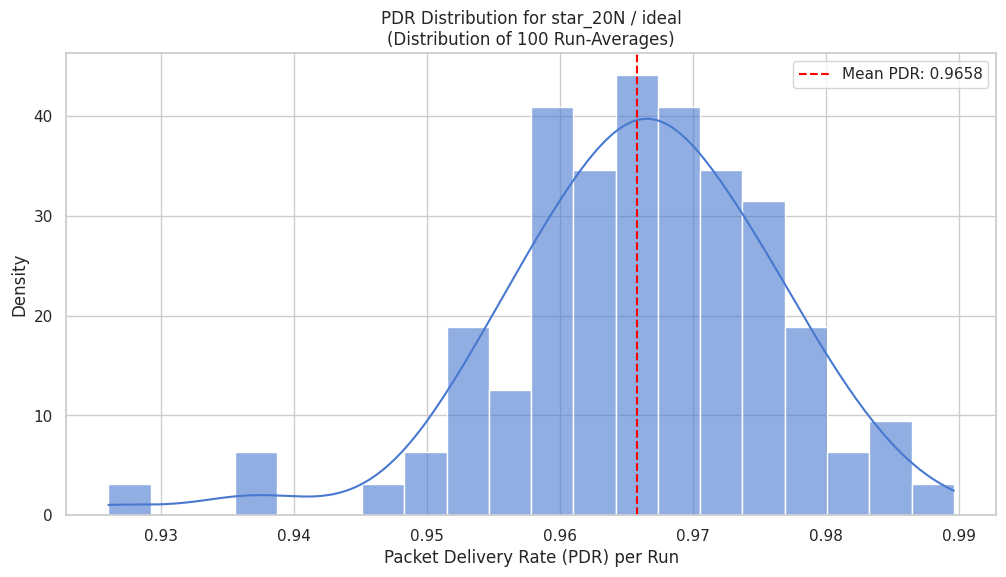


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0065 s
  Std. Dev. of Latency (all packets): 0.0026 s
  (Based on 55037 total packets delivered across all runs)


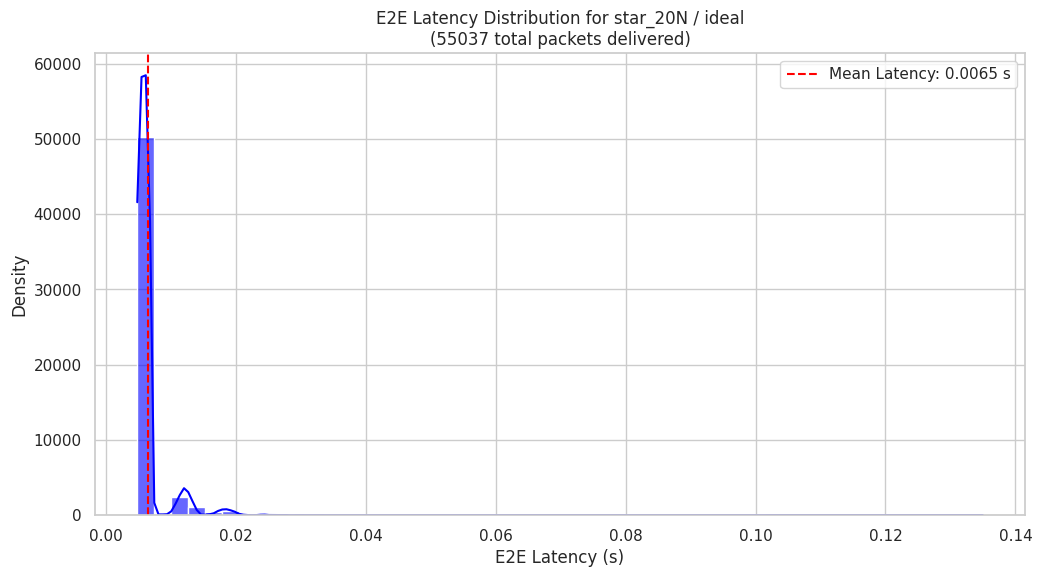



Processing Configuration: star_20N / lossy
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9146
  Std. Dev. of PDR (run-to-run): 0.0210
  (Based on 100 simulation runs)


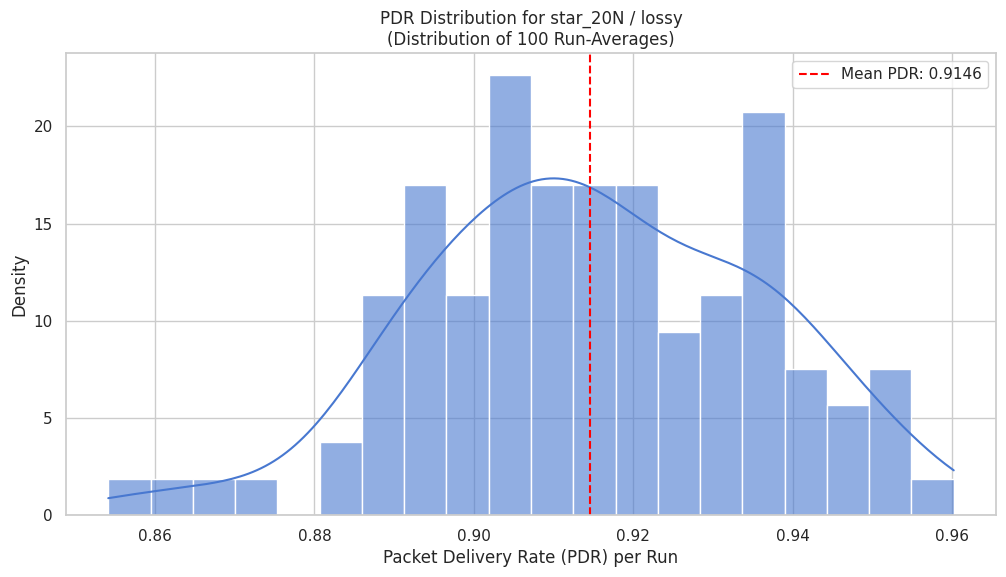


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0115 s
  Std. Dev. of Latency (all packets): 0.0074 s
  (Based on 52021 total packets delivered across all runs)


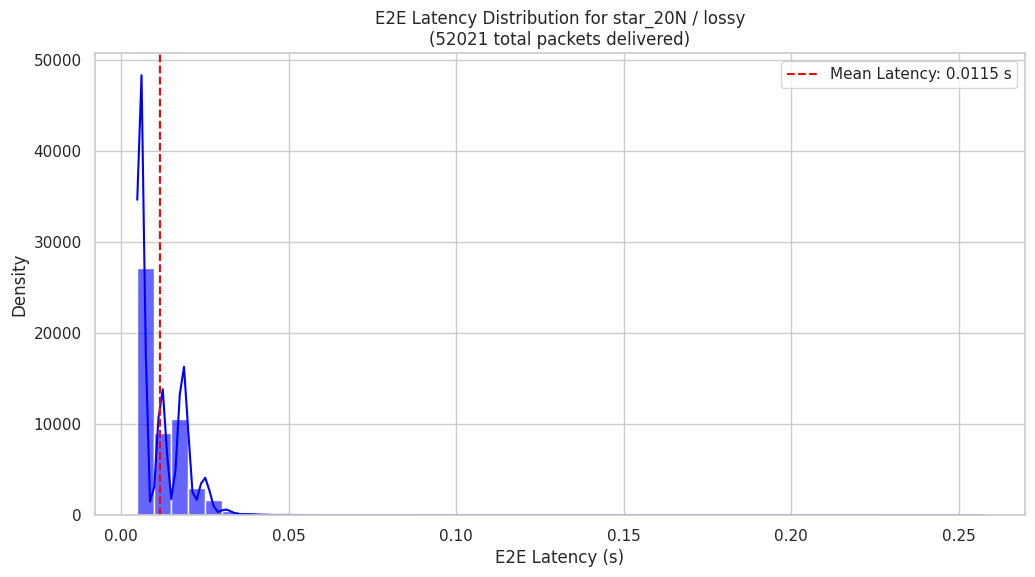



Processing Configuration: star_20N / stable
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.9661
  Std. Dev. of PDR (run-to-run): 0.0110
  (Based on 100 simulation runs)


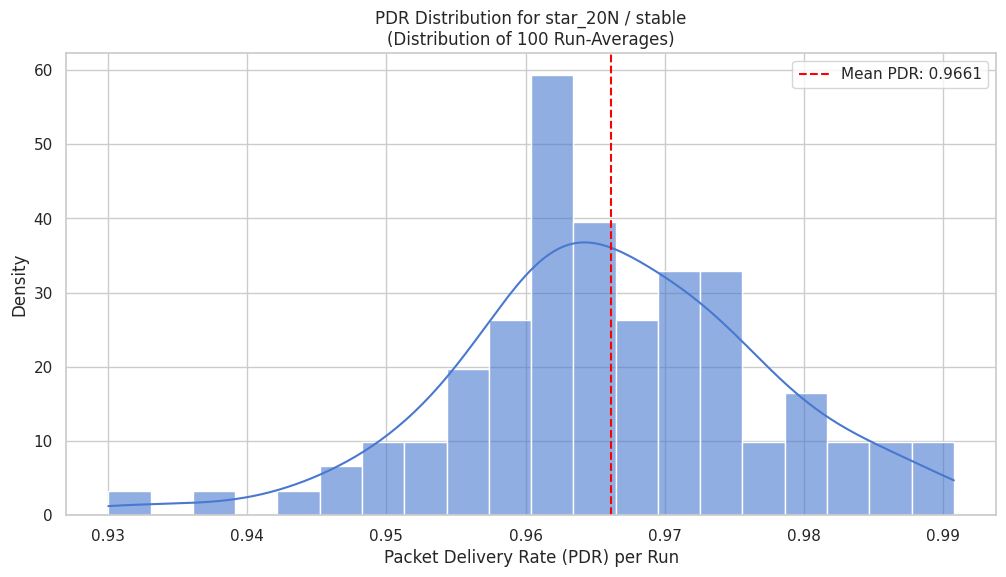


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0065 s
  Std. Dev. of Latency (all packets): 0.0026 s
  (Based on 55056 total packets delivered across all runs)


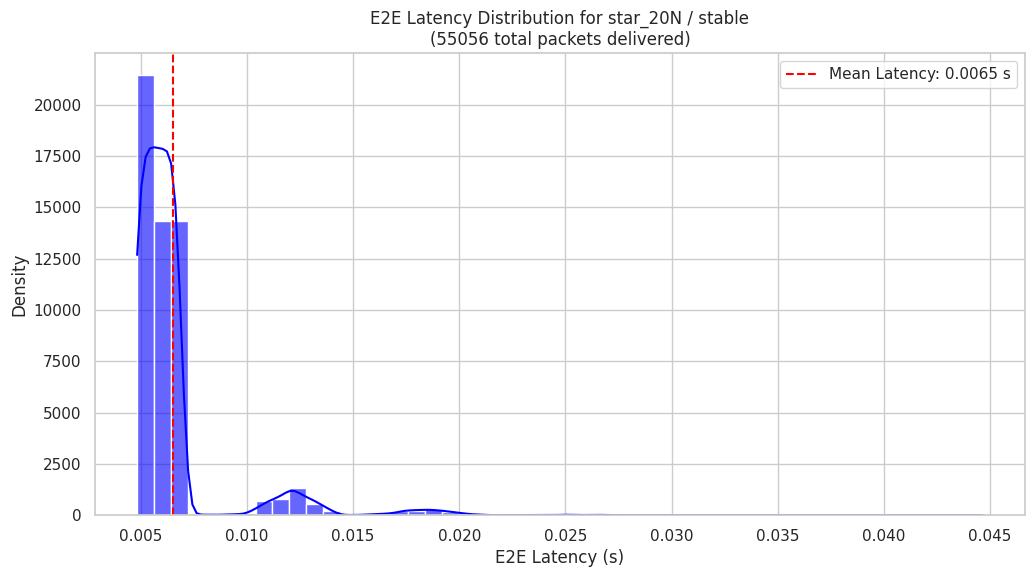



Processing Configuration: star_20N / stable_high_pl
  Found 100 simulation runs (seeds). Processing...


  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57/star_20N/stable_high_pl/12347_antithetic/log_PDR.csv
  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57/star_20N/stable_high_pl/12349_antithetic/log_PDR.csv
  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57/star_20N/stable_high_pl/12350_antithetic/log_PDR.csv
  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57/star_20N/stable_high_pl/12354/log_PDR.csv
  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57/star_20N/stable_high_pl/12357/log_PDR.csv
  - WARNING: PDR file not found, skipping: /home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57/star_20N/stable_high_pl/12359_antithetic/log_PDR.

  Processed 100 runs: Found 81 valid PDR logs and 81 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.5175
  Std. Dev. of PDR (run-to-run): 0.0945
  (Based on 81 simulation runs)


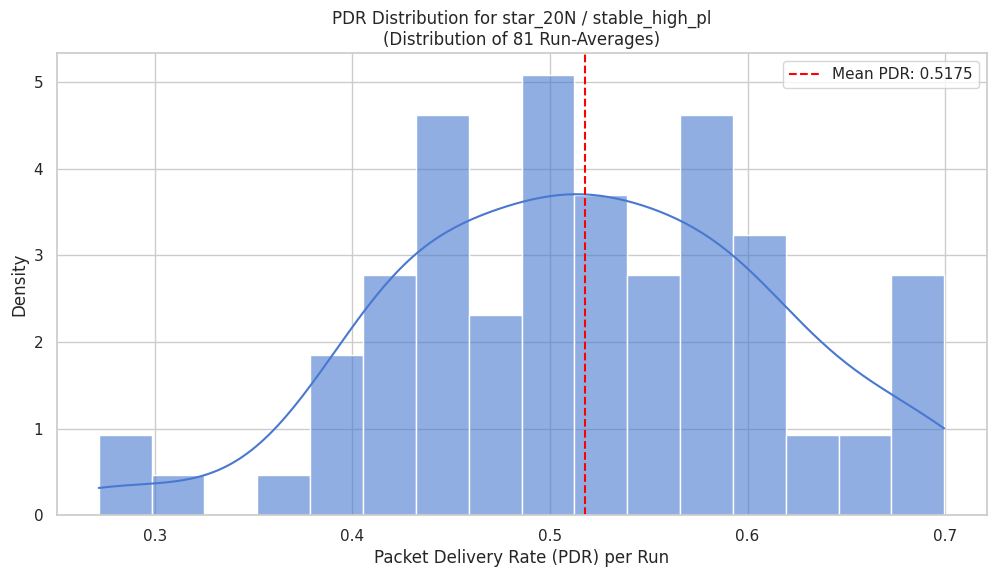


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0250 s
  Std. Dev. of Latency (all packets): 0.0181 s
  (Based on 18467 total packets delivered across all runs)


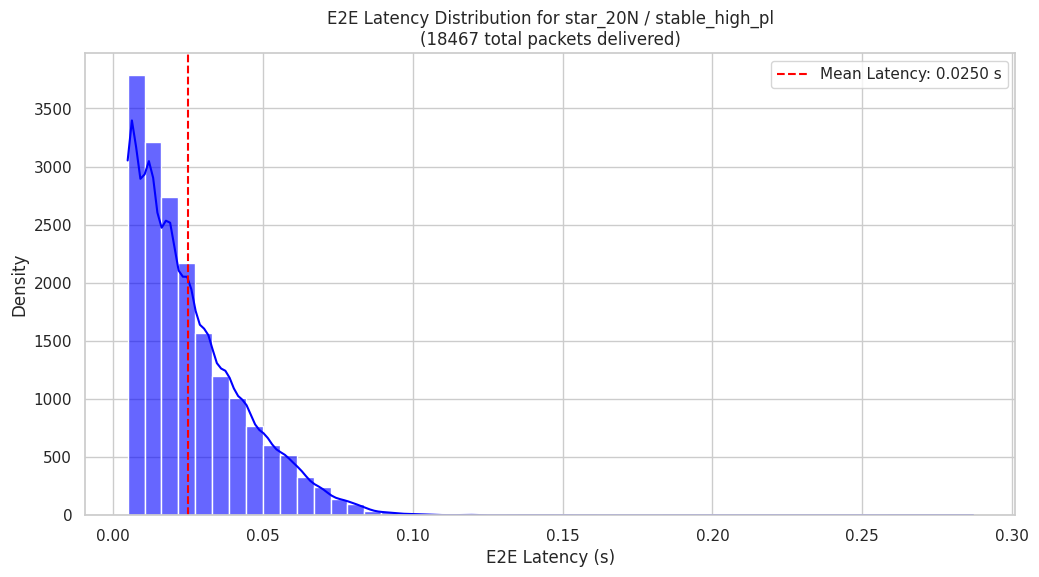



Processing Configuration: star_20N / stable_mid_pl
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.8954
  Std. Dev. of PDR (run-to-run): 0.0226
  (Based on 100 simulation runs)


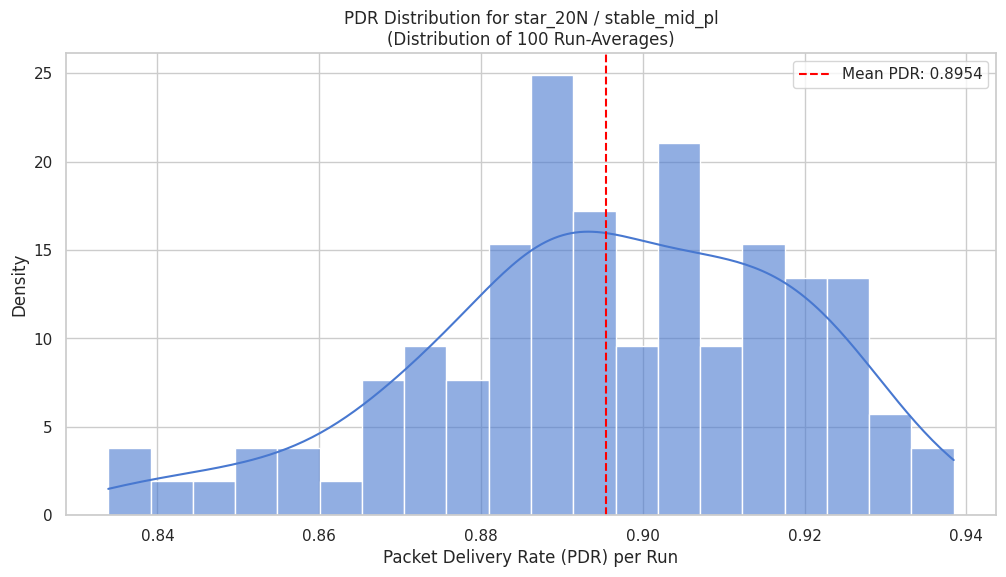


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0113 s
  Std. Dev. of Latency (all packets): 0.0070 s
  (Based on 50962 total packets delivered across all runs)


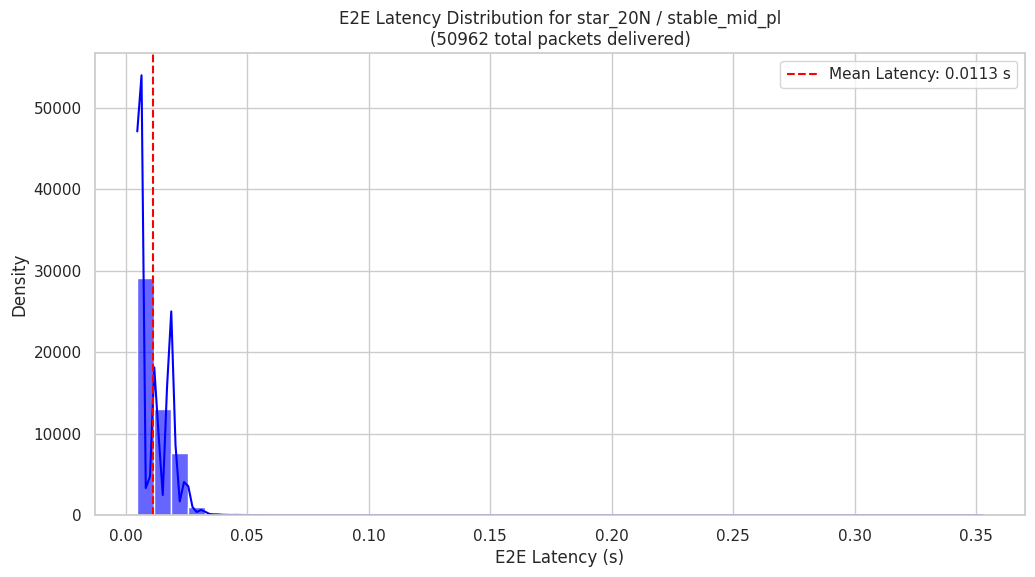



Processing Configuration: star_20N / unstable
  Found 100 simulation runs (seeds). Processing...
  Processed 100 runs: Found 100 valid PDR logs and 100 valid Latency logs.

--- PDR Results ---
  Mean PDR (averaged over runs): 0.4674
  Std. Dev. of PDR (run-to-run): 0.0763
  (Based on 100 simulation runs)


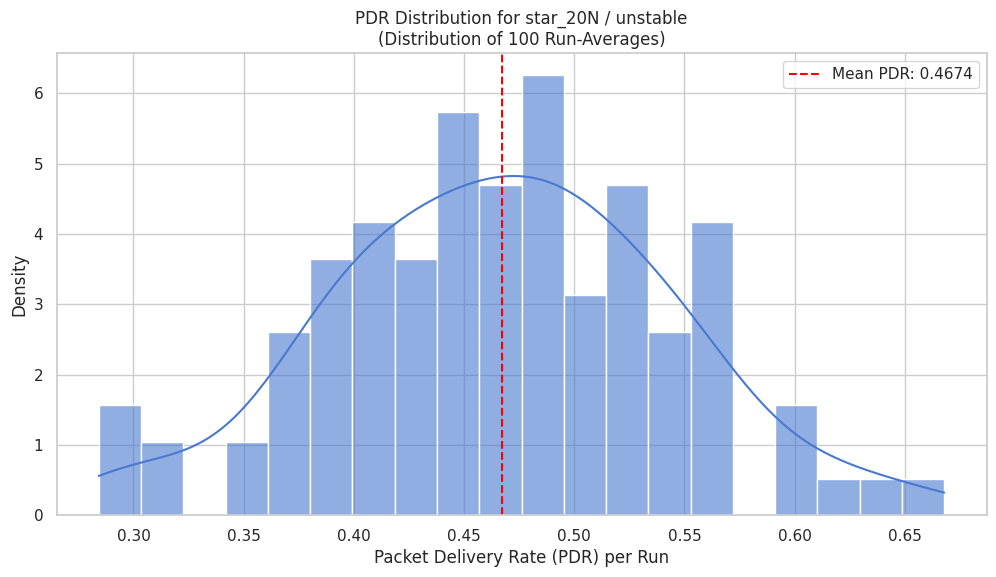


--- E2E Latency Results ---
  Mean Latency (averaged over all packets): 0.0232 s
  Std. Dev. of Latency (all packets): 0.0200 s
  (Based on 23483 total packets delivered across all runs)


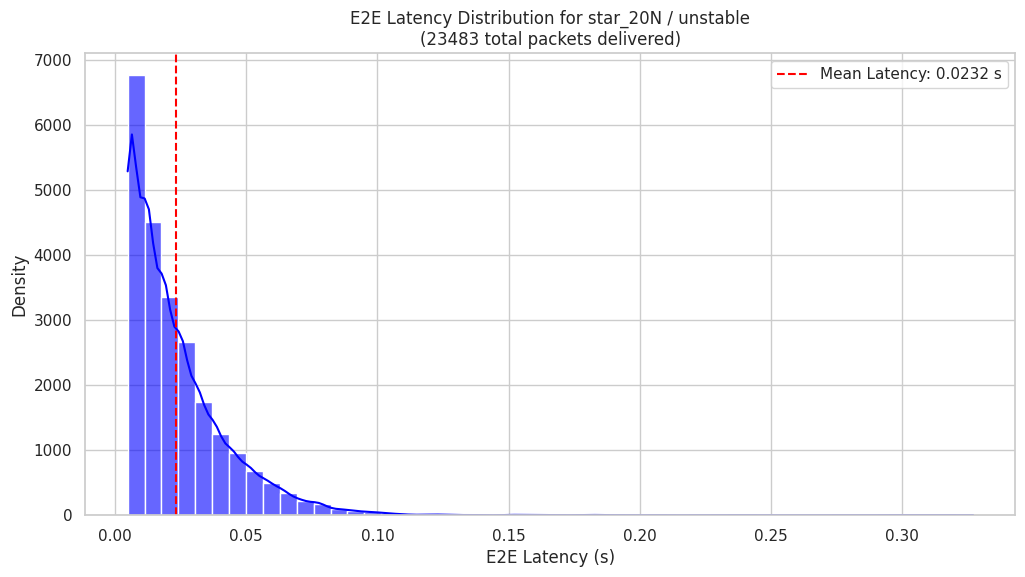



Analysis complete.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

# =============================================================================
# --- Configuration ---
# =============================================================================


# 1. Set this to the parent directory containing your topology folders
#    (e.g., the 'poisson_traffic' folder that holds 'random_20nodes')
PATH_TO_RESULTS_PARENT_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251116_23-04-57")

# 2. Set this to the specific topology folder you want to analyze
#    (e.g., "random_20nodes" or "cluster-tree_20nodes")
TOPOLOGY_FOLDER_TO_ANALYZE = "star_20N"

# --- End of Configuration ---


# Log file names (as defined in run_simulation.py and monitors)
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

# Set plot style for better aesthetics
sns.set(style="whitegrid", palette="muted")
# Suppress warnings from seaborn when data is missing for KDE
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# =============================================================================
# --- Helper Functions ---
# =============================================================================

def process_pdr_file(file_path):
    """
    Reads a single PDR log file from one run (seed).
    Calculates the PDR for that run (which is the mean of the 'delivered' column).
    Returns the PDR value (float) or None if the file is invalid.
    """
    try:
        # Load the CSV. We use skipinitialspace to handle
        # the potential leading space in the header row.
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:
            print(f"  - WARNING: PDR file is empty, skipping: {file_path}", file=sys.stderr)
            return None
        
        #
        # The 'delivered' column is 0 or 1. The mean of this column
        # is the Packet Delivery Rate for this simulation run.
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        # This is not an error, it just means the simulation run failed to
        # produce this file. We will report it and skip it.
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        print(f"  - WARNING: PDR file is empty (EmptyDataError), skipping: {file_path}", file=sys.stderr)
        return None
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None

def process_latency_file(file_path):
    """
    Reads a single E2E Latency log file from one run (seed).
    Returns a list of all individual packet latencies from that run.
    Returns an empty list if the file is invalid or no packets were delivered.
    """
    try:
        #
        # The 'latency' column contains the E2E latency for each received packet.
        df_lat = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_lat.empty:
            # This is not an error; it just means PDR was 0.
            return []
        
        if 'latency' not in df_lat.columns:
            print(f"  - ERROR: 'latency' column not found in: {file_path}", file=sys.stderr)
            return []
            
        # Return all latencies from this run
        return df_lat['latency'].tolist()
        
    except FileNotFoundError:
        # This is expected if PDR was 0 for the run.
        return [] 
    except pd.errors.EmptyDataError:
        # This is also expected if PDR was 0.
        return []
    except Exception as e:
        print(f"  - ERROR processing Latency file {file_path}: {e}", file=sys.stderr)
        return []

# =============================================================================
# --- Main Analysis Script ---
# =============================================================================

# Construct the full path to the specific topology folder we want to analyze
analysis_base_path = PATH_TO_RESULTS_PARENT_FOLDER / TOPOLOGY_FOLDER_TO_ANALYZE

if not analysis_base_path.is_dir():
    print(f"ERROR: Analysis directory not found at: {analysis_base_path}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_PARENT_FOLDER' and 'TOPOLOGY_FOLDER_TO_ANALYZE' variables.", file=sys.stderr)
else:
    print(f"Starting analysis for topology: {TOPOLOGY_FOLDER_TO_ANALYZE}\n")
    
    # Find channel folders (e.g., 'stable', 'lossy', 'unstable')
    channel_dirs = sorted([d for d in analysis_base_path.iterdir() if d.is_dir()])
    
    if not channel_dirs:
        print(f"  No channel folders (e.g., 'stable', 'lossy') found in {analysis_base_path}", file=sys.stderr)

    # --- Iterate over each Channel Configuration ---
    for channel_dir in channel_dirs:
        config_name = f"{TOPOLOGY_FOLDER_TO_ANALYZE} / {channel_dir.name}"
        print("="*70)
        print(f"Processing Configuration: {config_name}")
        print("="*70)

        # Find all replication runs (seed folders) for this configuration
        seed_dirs = sorted([d for d in channel_dir.iterdir() if d.is_dir()])
        
        if not seed_dirs:
            print(f"  No simulation runs (seed folders) found in {channel_dir}.\n")
            continue

        # These lists will store the metrics
        all_run_pdrs = []
        all_packet_latencies = []
        
        print(f"  Found {len(seed_dirs)} simulation runs (seeds). Processing...")
        valid_pdr_runs = 0
        valid_latency_runs = 0

        # --- Iterate over each Run (Seed) ---
        for seed_dir in seed_dirs:
            # --- PDR Processing ---
            pdr_file = seed_dir / PDR_LOG_FILE
            run_pdr = process_pdr_file(pdr_file)
            if run_pdr is not None:
                all_run_pdrs.append(run_pdr)
                valid_pdr_runs += 1

            # --- Latency Processing ---
            latency_file = seed_dir / LATENCY_LOG_FILE
            run_latencies = process_latency_file(latency_file)
            if run_latencies:
                all_packet_latencies.extend(run_latencies)
                valid_latency_runs += 1
        
        print(f"  Processed {len(seed_dirs)} runs: Found {valid_pdr_runs} valid PDR logs and {valid_latency_runs} valid Latency logs.")


        # --- Analyze and Plot PDR ---
        if not all_run_pdrs:
            print("\n  No valid PDR data found for this configuration.")
        else:
            pdr_array = np.array(all_run_pdrs)
            mean_pdr = np.mean(pdr_array)
            std_pdr = np.std(pdr_array)
            
            print("\n--- PDR Results ---")
            print(f"  Mean PDR (averaged over runs): {mean_pdr:.4f}")
            print(f"  Std. Dev. of PDR (run-to-run): {std_pdr:.4f}")
            print(f"  (Based on {len(pdr_array)} simulation runs)")

            # Plot PDR Distribution
            plt.figure(figsize=(12, 6))
            ax_pdr = sns.histplot(pdr_array, kde=True, bins=max(10, len(pdr_array)//5), stat="density", alpha=0.6)
            ax_pdr.axvline(mean_pdr, color='red', linestyle='--', 
                           label=f'Mean PDR: {mean_pdr:.4f}')
            
            ax_pdr.set_title(f'PDR Distribution for {config_name}\n(Distribution of {len(pdr_array)} Run-Averages)')
            ax_pdr.set_xlabel('Packet Delivery Rate (PDR) per Run')
            ax_pdr.set_ylabel('Density')
            ax_pdr.legend()
            plt.show() # Display the plot in Jupyter

        # --- Analyze and Plot Latency ---
        if not all_packet_latencies:
            print("\n  No Latency data found for this configuration (no packets were delivered).")
        else:
            latency_array = np.array(all_packet_latencies)
            mean_latency = np.mean(latency_array)
            std_latency = np.std(latency_array)
            
            print("\n--- E2E Latency Results ---")
            print(f"  Mean Latency (averaged over all packets): {mean_latency:.4f} s")
            print(f"  Std. Dev. of Latency (all packets): {std_latency:.4f} s")
            print(f"  (Based on {len(latency_array)} total packets delivered across all runs)")

            # Plot Latency Distribution
            plt.figure(figsize=(12, 6))
            
            # Check for wide variance to decide on log scale
            min_lat = np.min(latency_array)
            max_lat = np.max(latency_array)
            # Add epsilon (1e-9) to avoid division by zero if min_lat is 0
            #use_log_scale = (max_lat / (min_lat + 1e-9)) > 100
            use_log_scale = False

            # *** FIX IS HERE ***
            # 1. Create the plot and get the axes object
            ax_lat = sns.histplot(latency_array, kde=True, bins=50, alpha=0.6,
                                  color='blue' if not use_log_scale else 'purple')
            
            # 2. Add the vertical line
            ax_lat.axvline(mean_latency, color='red', linestyle='--', 
                           label=f'Mean Latency: {mean_latency:.4f} s')
            
            title = f'E2E Latency Distribution for {config_name}\n({len(latency_array)} total packets delivered)'
            xlabel = 'E2E Latency (s)'
            
            # 3. Apply log scale using matplotlib directly, which avoids the error
            if use_log_scale:
                ax_lat.set_xscale('log')
                xlabel += ' [Scale]'
                
            ax_lat.set_title(title)
            ax_lat.set_xlabel(xlabel)
            ax_lat.set_ylabel('Density')
            ax_lat.legend()
            plt.show() # Display the plot in Jupyter
            
        print("\n")

print("="*70)
print("Analysis complete.")